# Credit Risk Modeling

The Author: Nhan TV

## Import Library

In [1]:
import numpy as np
import pandas as pd

## Import Data

The dataset contains all available data for more than 800,000 consumer loans issued from 2007 to 2015 by Lending Club: a large US peer-to-peer lending company. There are several different versions of this dataset. We have used a version available on kaggle.com. You can find it here: https://www.kaggle.com/wendykan/lending-club-loan-data/version/1 We divided the data into two periods because we assume that some data are available at the moment when we need to build Expected Loss models, and some data comes from applications after. Later, we investigate whether the applications we have after we built the Probability of Default (PD) model have similar characteristics with the applications we used to build the PD model.

In [2]:
loan_data_backup = pd.read_csv('gs://credit-risk-modeling/loan_data_2007_2014.csv', index_col = 0)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loan_data = loan_data_backup.copy()

In [4]:
#pd.options.display.max_columns = None

In [5]:
#loan_data

In [6]:
#loan_data.columns.values

In [7]:
#loan_data.info()

## General Preprocessing

### Preprocessing few continuous variables

### emp_length

Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

In [8]:
loan_data["emp_length"].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [21]:
loan_data["emp_length_int"] = loan_data["emp_length"].str.replace('\+ years', '')
loan_data["emp_length_int"] = loan_data["emp_length_int"].str.replace('< 1 year', str(0))
loan_data["emp_length_int"] = loan_data["emp_length_int"].str.replace(' years', '')
loan_data["emp_length_int"] = loan_data["emp_length_int"].str.replace(' year', '')
loan_data["emp_length_int"].fillna(str(0), inplace = True)

In [10]:
type(loan_data["emp_length_int"][0])

str

In [22]:
loan_data["emp_length_int"] = pd.to_numeric(loan_data["emp_length_int"])

In [12]:
loan_data["emp_length_int"].dtype

dtype('int64')

### earliest_cr_line

The month the borrower's earliest reported credit line was opened

In [13]:
loan_data['earliest_cr_line'].head()

0    Jan-85
1    Apr-99
2    Nov-01
3    Feb-96
4    Jan-96
Name: earliest_cr_line, dtype: object

In [5]:
loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format = '%b-%y')
# Extracts the date and the time from a string variable that is in a given format.

In [15]:
loan_data['earliest_cr_line_date'][0]

Timestamp('1985-01-01 00:00:00')

In [16]:
(pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date']).head()
# Calculates the difference between two dates and times.

0   12022 days
1    6819 days
2    5874 days
3    7974 days
4    8005 days
Name: earliest_cr_line_date, dtype: timedelta64[ns]

In [6]:
# Assume we are now in December 2017
loan_data['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date']) / np.timedelta64(1, 'M')))

In [18]:
 print(np.timedelta64(1, 'M'))

1 months


In [19]:
loan_data['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        239.482430
std          93.974829
min        -612.000000
25%         183.000000
50%         225.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [7]:
(loan_data.loc[: , ['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']][loan_data['mths_since_earliest_cr_line'] < 0]).head()
# We take three columns from the dataframe. Then, we display them only for the rows where a variable has negative value.

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-537.0
1770,Sep-68,2068-09-01,-609.0
2799,Sep-64,2064-09-01,-561.0
3282,Sep-67,2067-09-01,-597.0
3359,Feb-65,2065-02-01,-566.0


In [8]:
loan_data['mths_since_earliest_cr_line'][loan_data['mths_since_earliest_cr_line'] < 0] = loan_data['mths_since_earliest_cr_line'].max()
# We set the rows that had negative differences to the maximum value.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
min(loan_data['mths_since_earliest_cr_line'])
# Calculates and shows the minimum value of a column.

73.0

## term

The number of payments on the loan. Values are in months and can be either 36 or 60.

In [23]:
loan_data['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [10]:
loan_data['term_int'] = loan_data['term'].str.replace(' months', '')

In [25]:
loan_data['term_int'].unique()

array([' 36', ' 60'], dtype=object)

In [11]:
loan_data['term_int'] = pd.to_numeric(loan_data['term_int'])

In [27]:
loan_data['term_int'].unique()

array([36, 60])

## issue_d

The month which the loan was funded

In [28]:
loan_data['issue_d'].unique()

array(['Dec-11', 'Nov-11', 'Oct-11', 'Sep-11', 'Aug-11', 'Jul-11',
       'Jun-11', 'May-11', 'Apr-11', 'Mar-11', 'Feb-11', 'Jan-11',
       'Dec-10', 'Nov-10', 'Oct-10', 'Sep-10', 'Aug-10', 'Jul-10',
       'Jun-10', 'May-10', 'Apr-10', 'Mar-10', 'Feb-10', 'Jan-10',
       'Dec-09', 'Nov-09', 'Oct-09', 'Sep-09', 'Aug-09', 'Jul-09',
       'Jun-09', 'May-09', 'Apr-09', 'Mar-09', 'Feb-09', 'Jan-09',
       'Dec-08', 'Nov-08', 'Oct-08', 'Sep-08', 'Aug-08', 'Jul-08',
       'Jun-08', 'May-08', 'Apr-08', 'Mar-08', 'Feb-08', 'Jan-08',
       'Dec-07', 'Nov-07', 'Oct-07', 'Sep-07', 'Aug-07', 'Jul-07',
       'Jun-07', 'Dec-13', 'Nov-13', 'Oct-13', 'Sep-13', 'Aug-13',
       'Jul-13', 'Jun-13', 'May-13', 'Apr-13', 'Mar-13', 'Feb-13',
       'Jan-13', 'Dec-12', 'Nov-12', 'Oct-12', 'Sep-12', 'Aug-12',
       'Jul-12', 'Jun-12', 'May-12', 'Apr-12', 'Mar-12', 'Feb-12',
       'Jan-12', 'Dec-14', 'Nov-14', 'Oct-14', 'Sep-14', 'Aug-14',
       'Jul-14', 'Jun-14', 'May-14', 'Apr-14', 'Mar-14', 'Feb-

In [12]:
loan_data['issue_d_date'] = pd.to_datetime(loan_data['issue_d'], format = '%b-%y')

In [30]:
loan_data['issue_d_date'][0]

Timestamp('2011-12-01 00:00:00')

In [13]:
loan_data['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01')-loan_data['issue_d_date'])/np.timedelta64(1, 'M')))

In [32]:
loan_data['mths_since_issue_d'].describe()

count    466285.000000
mean         51.255187
std          14.340154
min          36.000000
25%          41.000000
50%          47.000000
75%          57.000000
max         126.000000
Name: mths_since_issue_d, dtype: float64

## Preprocessing few discrete variables

In [33]:
loan_data.info()
# Displays column names, complete (non-missing) cases per column, and datatype per column.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 80 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id                           466285 non-null  int64         
 1   member_id                    466285 non-null  int64         
 2   loan_amnt                    466285 non-null  int64         
 3   funded_amnt                  466285 non-null  int64         
 4   funded_amnt_inv              466285 non-null  float64       
 5   term                         466285 non-null  object        
 6   int_rate                     466285 non-null  float64       
 7   installment                  466285 non-null  float64       
 8   grade                        466285 non-null  object        
 9   sub_grade                    466285 non-null  object        
 10  emp_title                    438697 non-null  object        
 11  emp_length                

We are going to preprocess the following discrete variables: grade, sub_grade, home_ownership, verification_status, loan_status, purpose, addr_state, initial_list_status. Most likely, we are not going to use sub_grade, as it overlaps with grade.
<li>sub_grade: LC assigned loan subgrade. If an application passes the initial credit screening criteria, the characteristics of the application are assessed by Lending Club’s proprietary scoring models which can either decline or approve the applicant. The initial scoring model provides the application with a score, which when combined with the applicant’s FICO score and certain other credit attributes arrives at a Model Rank. The Model Rank is based upon an internally developed algorithm which analyzes the performance of borrower members and takes into account FICO score, credit attributes, and other application data. The Model Rank is between 1 and 25 and corresponds to a Base Risk Sub-Grade.
<li>The initial listing status of the loan. Possible values are – W, F.
<li>total_rev_hi_lim: Total revolving high credit/credit limit.
<li>funded_amnt: The total amount committed to that loan at that point in time.

In [34]:
loan_data['initial_list_status'].unique()

array(['f', 'w'], dtype=object)

In [35]:
pd.get_dummies(loan_data['grade']).head()

,A,B,C,D,E,F,G
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0


In [14]:
pd.get_dummies(loan_data['grade'], prefix = 'grade', prefix_sep = ':').head()
# Create dummy variables from a variable.

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0


In [15]:
# grade, sub_grade, home_ownership, verification_status, loan_status, purpose, addr_state, initial_list_status
loan_data_dummies = [pd.get_dummies(loan_data['grade'], prefix = 'grade', prefix_sep = ':'),
                     pd.get_dummies(loan_data['sub_grade'], prefix = 'sub_grade', prefix_sep = ':'),
                     pd.get_dummies(loan_data['home_ownership'], prefix = 'home_ownership', prefix_sep = ':'),
                     pd.get_dummies(loan_data['verification_status'], prefix = 'verification_status', prefix_sep = ':'),
                     pd.get_dummies(loan_data['loan_status'], prefix = 'loan_status', prefix_sep = ':'),
                     pd.get_dummies(loan_data['purpose'], prefix = 'purpose', prefix_sep = ':'),
                     pd.get_dummies(loan_data['addr_state'], prefix = 'addr_state', prefix_sep = ':'),
                     pd.get_dummies(loan_data['initial_list_status'], prefix = 'initial_list_status', prefix_sep = ':')]
# We create dummy variables from all 8 original independent variables, and save them into a list.

In [16]:
loan_data_dummies = pd.concat(loan_data_dummies, axis = 1)

In [39]:
loan_data_dummies.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,...,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [17]:
loan_data = pd.concat([loan_data, loan_data_dummies], axis = 1)
# Concatenates two dataframes.

In [41]:
loan_data.columns.values
# Displays all column names.

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
       'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint

## Check for missing values and clean

### total_rev_hi_lim: Total revolving high credit/credit limit.

In [42]:
loan_data.isnull().head()
# It returns 'False' if a value is not missing and 'True' if a value is missing, for each value in a dataframe.

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [43]:
pd.options.display.max_rows = None
# Sets the pandas dataframe options to display all columns/ rows.
loan_data.isnull().sum()

id                                                                      0
member_id                                                               0
loan_amnt                                                               0
funded_amnt                                                             0
funded_amnt_inv                                                         0
term                                                                    0
int_rate                                                                0
installment                                                             0
grade                                                                   0
sub_grade                                                               0
emp_title                                                           27588
emp_length                                                          21008
home_ownership                                                          0
annual_inc                            

In [18]:
# 'Total revolving high credit/ credit limit', so it makes sense that the missing values are equal to funded_amnt.
loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'], inplace=True)

In [45]:
loan_data['total_rev_hi_lim'].isnull().sum()

0

### annual_inc: The self-reported annual income provided by the borrower during registration.

In [19]:
loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(), inplace = True)

In [47]:
loan_data['annual_inc'].isnull().sum()

0

<li>‘mths_since_earliest_cr_line’

<li>‘acc_now_delinq’:The number of accounts on which the borrower is now delinquent.

<li>‘total_acc’:The total number of credit lines currently in the borrower's credit file
<li>‘pub_rec’: Number of derogatory public records
<li>‘open_acc’: the number of open credit lines in the borrower's credit file.
<li>‘inq_last_6mths’:The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
<li>‘delinq_2yrs’:The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
<li>‘emp_length_int’

In [23]:
loan_data['mths_since_earliest_cr_line'].fillna(0, inplace = True)
loan_data['acc_now_delinq'].fillna(0, inplace = True)
loan_data['total_acc'].fillna(0, inplace = True)
loan_data['pub_rec'].fillna(0, inplace = True)
loan_data['open_acc'].fillna(0, inplace = True)
loan_data['inq_last_6mths'].fillna(0, inplace = True)
loan_data['delinq_2yrs'].fillna(0, inplace = True)
loan_data['emp_length_int'].fillna(0, inplace = True)

# PD model

## Data preparation

### Dependent Variable. Good/ Bad (Default) Definition. Default and Non-default Accounts.

In [49]:
loan_data['loan_status'].unique()
# Displays unique values of a column.

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [50]:
loan_data['loan_status'].value_counts()
# Calculates the number of observations for each unique value of a variable.

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [51]:
loan_data['loan_status'].count()

466285

In [52]:
loan_data['loan_status'].value_counts() / loan_data['loan_status'].count()
# We divide the number of observations for each unique value of a variable by the total number of observations.

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

In [24]:
# Good/ Bad Definition
loan_data['good_bad'] = np.where(loan_data['loan_status'].isin(['Charged Off', 'Default',
                                                       'Does not meet the credit policy. Status:Charged Off',
                                                       'Late (31-120 days)']), 0, 1)
# We create a new variable that has the value of '0' if a condition is met, and the value of '1' if it is not met.

In [25]:
loan_data['good_bad'].head()

0    1
1    0
2    1
3    1
4    1
Name: good_bad, dtype: int64

## Splitting Data

In [26]:
from sklearn.model_selection import train_test_split
# Imports the libraries we need.

In [27]:
loan_data_inputs_train, loan_data_inputs_test, loan_data_targets_train, loan_data_targets_test = train_test_split(loan_data.drop('good_bad', axis = 1), loan_data['good_bad'], test_size = 0.2, random_state = 42)
# We split two dataframes with inputs and targets, each into a train and test dataframe, and store them in variables.

In [57]:
loan_data_inputs_train.shape
# Displays the size of the dataframe.

(373028, 206)

In [58]:
loan_data_targets_train.shape
# Displays the size of the dataframe.

(373028,)

In [59]:
loan_data_inputs_test.shape
# Displays the size of the dataframe.

(93257, 206)

In [60]:
loan_data_targets_test.shape
# Displays the size of the dataframe

(93257,)

## Data Preparation: An Example

In [28]:
#####
df_inputs_prepr = loan_data_inputs_train
df_targets_prepr = loan_data_targets_train
#####
#df_inputs_prepr = loan_data_inputs_test
#df_targets_prepr = loan_data_targets_test

In [62]:
df_inputs_prepr['grade'].unique()
# Displays unique values of a column.

array(['A', 'C', 'D', 'B', 'E', 'F', 'G'], dtype=object)

In [29]:
df1 = pd.concat([df_inputs_prepr['grade'], df_targets_prepr], axis = 1)
# Concatenates two dataframes along the columns.
df1.head()

,grade,good_bad
427211,A,1
206088,C,1
136020,A,1
412305,D,0
36159,C,0


In [30]:
df1 = pd.concat([df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].count(),
                df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].mean()], axis = 1)
# Concatenates two dataframes along the columns.

In [65]:
df1.head()

,grade,good_bad,grade,good_bad
0,A,59759,A,0.961044
1,B,109730,B,0.921015
2,C,100245,C,0.885770
3,D,61498,D,0.846304
4,E,28612,E,0.805257


In [31]:
df1 = df1.iloc[:, [0, 1, 3]]
# Selects only columns with specific indexes.
df1.head()

,grade,good_bad,good_bad
0,A,59759,0.961044
1,B,109730,0.921015
2,C,100245,0.885770
3,D,61498,0.846304
4,E,28612,0.805257


In [32]:
df1.columns = [df1.columns.values[0], 'n_obs', 'prop_good']
# Changes the names of the columns of a dataframe.
df1.head()

,grade,n_obs,prop_good
0,A,59759,0.961044
1,B,109730,0.921015
2,C,100245,0.885770
3,D,61498,0.846304
4,E,28612,0.805257


In [33]:
df1['prop_n_obs'] = df1['n_obs'] / df1['n_obs'].sum()
# We divide the values of one column by he values of another column and save the result in a new variable.
df1.head()

,grade,n_obs,prop_good,prop_n_obs
0,A,59759,0.961044,0.160200
1,B,109730,0.921015,0.294160
2,C,100245,0.885770,0.268733
3,D,61498,0.846304,0.164862
4,E,28612,0.805257,0.076702


In [34]:
df1['n_good'] = df1['prop_good'] * df1['n_obs']
# We multiply the values of one column by he values of another column and save the result in a new variable.
df1['n_bad'] = (1 - df1['prop_good']) * df1['n_obs']
df1.head()

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad
0,A,59759,0.961044,0.160200,57431.0,2328.0
1,B,109730,0.921015,0.294160,101063.0,8667.0
2,C,100245,0.885770,0.268733,88794.0,11451.0
3,D,61498,0.846304,0.164862,52046.0,9452.0
4,E,28612,0.805257,0.076702,23040.0,5572.0


In [35]:
df1['prop_n_good'] = df1['n_good'] / df1['n_good'].sum()
df1['prop_n_bad'] = df1['n_bad'] / df1['n_bad'].sum()
df1.head()

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad
0,A,59759,0.961044,0.160200,57431.0,2328.0,0.172855,0.057090
1,B,109730,0.921015,0.294160,101063.0,8667.0,0.304178,0.212541
2,C,100245,0.885770,0.268733,88794.0,11451.0,0.267251,0.280813
3,D,61498,0.846304,0.164862,52046.0,9452.0,0.156647,0.231792
4,E,28612,0.805257,0.076702,23040.0,5572.0,0.069345,0.136642


In [36]:
df1['WoE'] = np.log(df1['prop_n_good'] / df1['prop_n_bad'])
# We take the natural logarithm of a variable and save the result in a nex variable.
df1.head()

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE
0,A,59759,0.961044,0.160200,57431.0,2328.0,0.172855,0.057090,1.107830
1,B,109730,0.921015,0.294160,101063.0,8667.0,0.304178,0.212541,0.358476
2,C,100245,0.885770,0.268733,88794.0,11451.0,0.267251,0.280813,-0.049503
3,D,61498,0.846304,0.164862,52046.0,9452.0,0.156647,0.231792,-0.391843
4,E,28612,0.805257,0.076702,23040.0,5572.0,0.069345,0.136642,-0.678267


In [37]:
df1 = df1.sort_values(['WoE'])
# Sorts a dataframe by the values of a given column.
df1 = df1.reset_index(drop = True)
# We reset the index of a dataframe and overwrite it.
df1.head()

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE
0,G,2654,0.727958,0.007115,1932.0,722.0,0.005815,0.017706,-1.113459
1,F,10530,0.754416,0.028228,7944.0,2586.0,0.023910,0.063417,-0.975440
2,E,28612,0.805257,0.076702,23040.0,5572.0,0.069345,0.136642,-0.678267
3,D,61498,0.846304,0.164862,52046.0,9452.0,0.156647,0.231792,-0.391843
4,C,100245,0.885770,0.268733,88794.0,11451.0,0.267251,0.280813,-0.049503


In [38]:
df1['diff_prop_good'] = df1['prop_good'].diff().abs()
# We take the difference between two subsequent values of a column. Then, we take the absolute value of the result.
df1['diff_WoE'] = df1['WoE'].diff().abs()
# We take the difference between two subsequent values of a column. Then, we take the absolute value of the result.
df1.head()

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE
0,G,2654,0.727958,0.007115,1932.0,722.0,0.005815,0.017706,-1.113459,NaN,NaN
1,F,10530,0.754416,0.028228,7944.0,2586.0,0.023910,0.063417,-0.975440,0.026458,0.138019
2,E,28612,0.805257,0.076702,23040.0,5572.0,0.069345,0.136642,-0.678267,0.050841,0.297173
3,D,61498,0.846304,0.164862,52046.0,9452.0,0.156647,0.231792,-0.391843,0.041047,0.286424
4,C,100245,0.885770,0.268733,88794.0,11451.0,0.267251,0.280813,-0.049503,0.039466,0.342340


In [39]:
df1['IV'] = (df1['prop_n_good'] - df1['prop_n_bad']) * df1['WoE']
df1['IV'] = df1['IV'].sum()
# We sum all values of a given column.
df1.head()

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,2654,0.727958,0.007115,1932.0,722.0,0.005815,0.017706,-1.113459,NaN,NaN,0.288636
1,F,10530,0.754416,0.028228,7944.0,2586.0,0.023910,0.063417,-0.975440,0.026458,0.138019,0.288636
2,E,28612,0.805257,0.076702,23040.0,5572.0,0.069345,0.136642,-0.678267,0.050841,0.297173,0.288636
3,D,61498,0.846304,0.164862,52046.0,9452.0,0.156647,0.231792,-0.391843,0.041047,0.286424,0.288636
4,C,100245,0.885770,0.268733,88794.0,11451.0,0.267251,0.280813,-0.049503,0.039466,0.342340,0.288636


## Preprocessing Discrete Variables: Automating Calculations

In [40]:
# WoE function for discrete unordered variables
def woe_discrete(df, discrete_variabe_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return(df)

In [41]:
# 'grade'
df_temp = woe_discrete(df_inputs_prepr, 'grade', df_targets_prepr)
# We execute the function we defined with the necessary arguments: a dataframe, a string, and a dataframe.
# We store the result in a dataframe.
df_temp.head()

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,2654,0.727958,0.007115,1932.0,722.0,0.005815,0.017706,-1.113459,NaN,NaN,0.288636
1,F,10530,0.754416,0.028228,7944.0,2586.0,0.023910,0.063417,-0.975440,0.026458,0.138019,0.288636
2,E,28612,0.805257,0.076702,23040.0,5572.0,0.069345,0.136642,-0.678267,0.050841,0.297173,0.288636
3,D,61498,0.846304,0.164862,52046.0,9452.0,0.156647,0.231792,-0.391843,0.041047,0.286424,0.288636
4,C,100245,0.885770,0.268733,88794.0,11451.0,0.267251,0.280813,-0.049503,0.039466,0.342340,0.288636


## Preprocessing Discrete Variables: Visualizing Results

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
# Imports the libraries we need.
sns.set()
# We set the default style of the graphs to the seaborn style. 

In [43]:
# Below we define a function that takes 2 arguments: a dataframe and a number.
# The number parameter has a default value of 0.
# This means that if we call the function and omit the number parameter, it will be executed with it having a value of 0.
# The function displays a graph.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    # Turns the values of the column with index 0 to strings, makes an array from these strings, and passes it to variable x.
    y = df_WoE['WoE']
    # Selects a column with label 'WoE' and passes it to variable y.
    plt.figure(figsize=(18, 6))
    # Sets the graph size to width 18 x height 6.
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    # Plots the datapoints with coordiantes variable x on the x-axis and variable y on the y-axis.
    # Sets the marker for each datapoint to a circle, the style line between the points to dashed, and the color to black.
    plt.xlabel(df_WoE.columns[0])
    # Names the x-axis with the name of the column with index 0.
    plt.ylabel('Weight of Evidence')
    # Names the y-axis 'Weight of Evidence'.
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    # Names the grapth 'Weight of Evidence by ' the name of the column with index 0.
    plt.xticks(rotation = rotation_of_x_axis_labels)
    # Rotates the labels of the x-axis a predefined number of degrees.

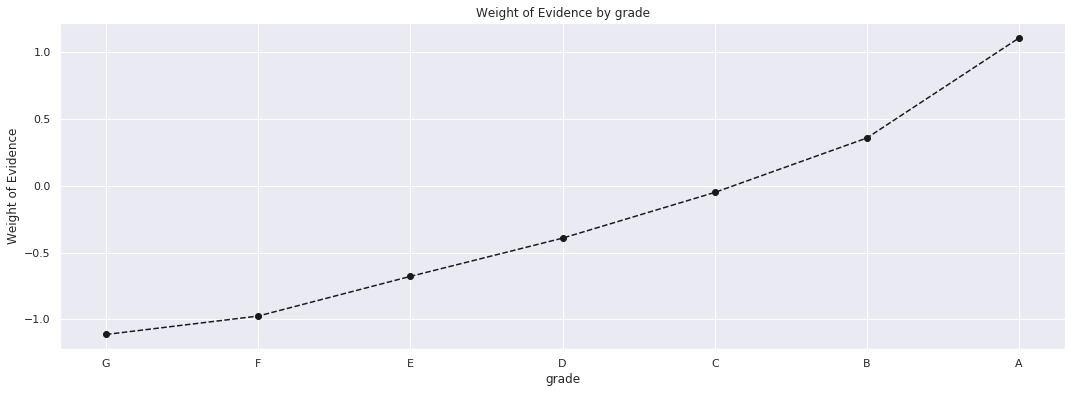

In [44]:
plot_by_woe(df_temp)
# We execute the function we defined with the necessary arguments: a dataframe.
# We omit the number argument, which means the function will use its default value, 0.

## Preprocessing Discrete Variables: Creating Dummy Variables, Part 1

In [80]:
# 'home_ownership'
df_temp = woe_discrete(df_inputs_prepr, 'home_ownership', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,OTHER,137,0.795620,0.000367,109.0,28.0,0.000328,0.000687,-0.738602,NaN,NaN,inf
1,NONE,40,0.850000,0.000107,34.0,6.0,0.000102,0.000147,-0.363144,0.054380,0.375458,inf
2,RENT,150599,0.873870,0.403720,131604.0,18995.0,0.396099,0.465815,-0.162123,0.023870,0.201021,inf
3,OWN,33295,0.892536,0.089256,29717.0,3578.0,0.089442,0.087743,0.019170,0.018666,0.181294,inf
4,MORTGAGE,188956,0.903835,0.506546,170785.0,18171.0,0.514026,0.445608,0.142834,0.011298,0.123663,inf
5,ANY,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,0.096165,inf,inf


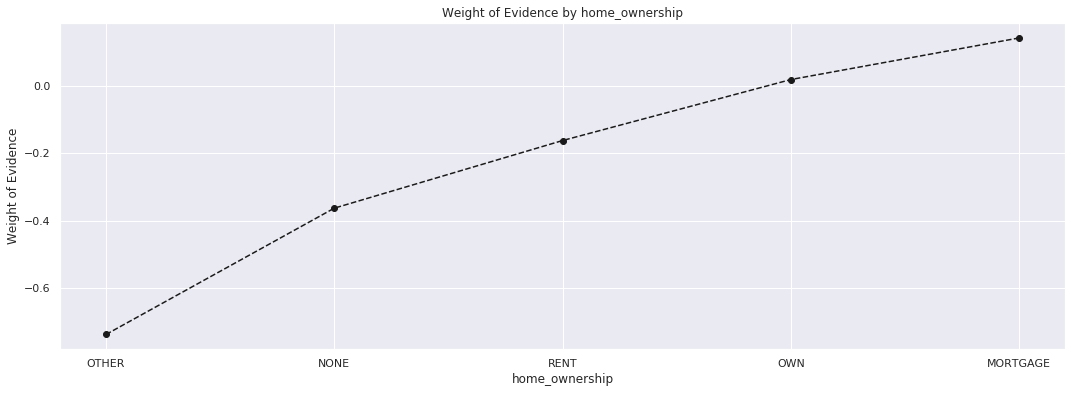

In [81]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [82]:
# There are many categories with very few observations and many categories with very different "good" %.
# Therefore, we create a new discrete variable where we combine some of the categories.
# 'OTHERS' and 'NONE' are riskiest but are very few. 'RENT' is the next riskiest.
# 'ANY' are least risky but are too few. Conceptually, they belong to the same category. Also, their inclusion would not change anything.
# We combine them in one category, 'RENT_OTHER_NONE_ANY'.
# We end up with 3 categories: 'RENT_OTHER_NONE_ANY', 'OWN', 'MORTGAGE'.
df_inputs_prepr['home_ownership:RENT_OTHER_NONE_ANY'] = sum([df_inputs_prepr['home_ownership:RENT'], df_inputs_prepr['home_ownership:OTHER'],
                                                      df_inputs_prepr['home_ownership:NONE'],df_inputs_prepr['home_ownership:ANY']])
# 'RENT_OTHER_NONE_ANY' will be the reference category.

# Alternatively:
#loan_data.loc['home_ownership' in ['RENT', 'OTHER', 'NONE', 'ANY'], 'home_ownership:RENT_OTHER_NONE_ANY'] = 1
#loan_data.loc['home_ownership' not in ['RENT', 'OTHER', 'NONE', 'ANY'], 'home_ownership:RENT_OTHER_NONE_ANY'] = 0
#loan_data.loc['loan_status' not in ['OWN'], 'home_ownership:OWN'] = 1
#loan_data.loc['loan_status' not in ['OWN'], 'home_ownership:OWN'] = 0
#loan_data.loc['loan_status' not in ['MORTGAGE'], 'home_ownership:MORTGAGE'] = 1
#loan_data.loc['loan_status' not in ['MORTGAGE'], 'home_ownership:MORTGAGE'] = 0

## Preprocessing Discrete Variables: Creating Dummy Variables, Part 2

In [83]:
# 'addr_state'
df_inputs_prepr['addr_state'].unique()

array(['SC', 'NJ', 'GA', 'MA', 'CA', 'IL', 'NC', 'NY', 'TX', 'CT', 'FL',
       'VA', 'UT', 'AZ', 'MD', 'WI', 'MI', 'CO', 'TN', 'IN', 'AL', 'NV',
       'MT', 'RI', 'OR', 'MN', 'KS', 'AK', 'PA', 'OH', 'WA', 'KY', 'OK',
       'MO', 'NM', 'HI', 'WV', 'LA', 'VT', 'AR', 'DC', 'SD', 'NH', 'WY',
       'MS', 'DE', 'IA', 'NE', 'ID', 'ME'], dtype=object)

In [84]:
len(df_inputs_prepr['addr_state'].unique())

50

In [85]:
df_temp = woe_discrete(df_inputs_prepr, 'addr_state', df_targets_prepr)
# We calculate weight of evidence.
df_temp

/opt/conda/lib/python3.7/site-packages/pandas/core/algorithms.py:1926: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,addr_state,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,NE,13,0.461538,0.000035,6.0,7.0,0.000018,0.000172,-2.251896,NaN,NaN,inf
1,IA,13,0.769231,0.000035,10.0,3.0,0.000030,0.000074,-0.893772,0.307692,1.358123,inf
2,NV,5221,0.864585,0.013996,4514.0,707.0,0.013586,0.017338,-0.243837,0.095355,0.649935,inf
3,FL,25211,0.875808,0.067585,22080.0,3131.0,0.066456,0.076782,-0.144425,0.011223,0.099411,inf
4,HI,2001,0.877061,0.005364,1755.0,246.0,0.005282,0.006033,-0.132852,0.001253,0.011573,inf
5,AL,4671,0.877328,0.012522,4098.0,573.0,0.012334,0.014052,-0.130376,0.000267,0.002476,inf
6,NM,2075,0.883373,0.005563,1833.0,242.0,0.005517,0.005935,-0.072973,0.006045,0.057403,inf
7,VA,11366,0.883864,0.030470,10046.0,1320.0,0.030236,0.032370,-0.068202,0.000491,0.004771,inf
8,NY,32211,0.883984,0.086350,28474.0,3737.0,0.085701,0.091643,-0.067037,0.000120,0.001165,inf
9,OK,3284,0.884287,0.008804,2904.0,380.0,0.008740,0.009319,-0.064072,0.000304,0.002965,inf


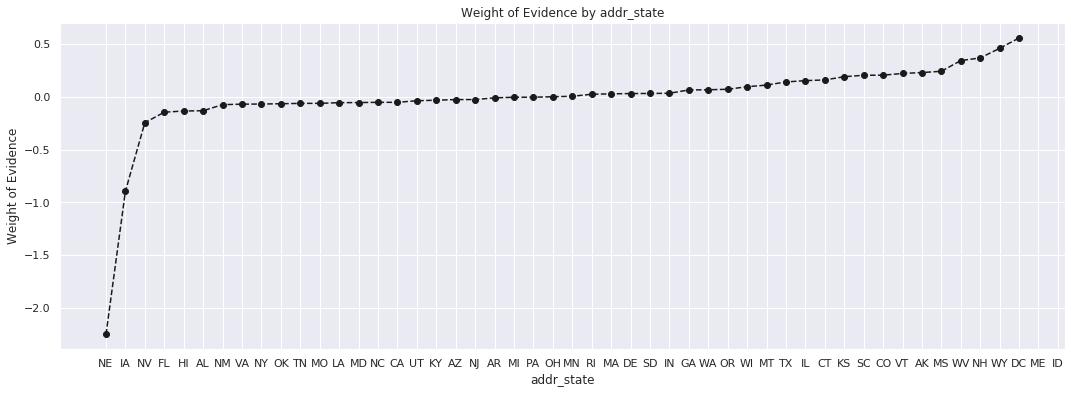

In [86]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [87]:
if ['addr_state:ND'] in df_inputs_prepr.columns.values:
    pass
else:
    df_inputs_prepr['addr_state:ND'] = 0

In [88]:
len(df_inputs_prepr['addr_state'].unique())

50

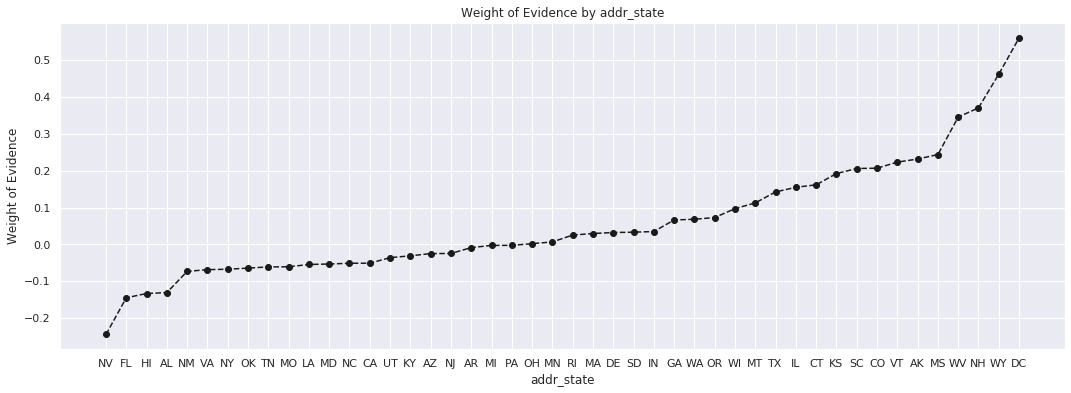

In [89]:
plot_by_woe(df_temp.iloc[2: -2, : ])
# We plot the weight of evidence values.

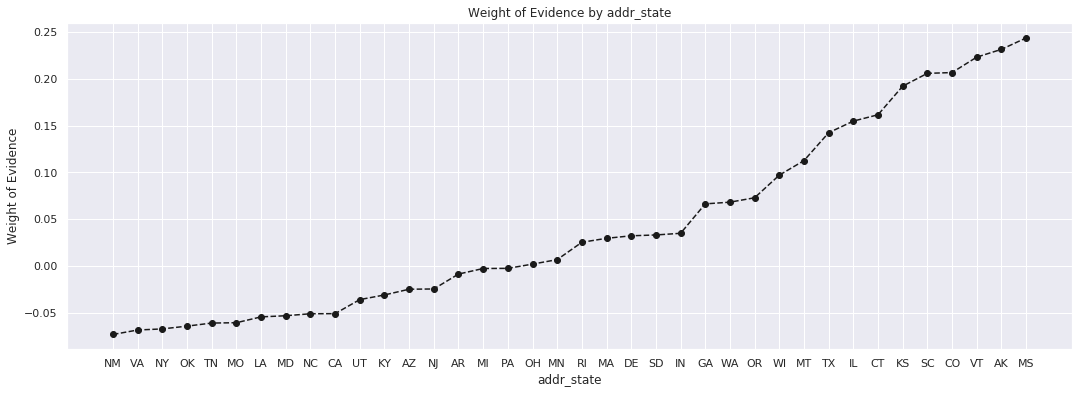

In [90]:
plot_by_woe(df_temp.iloc[6: -6, : ])
# We plot the weight of evidence values.

In [91]:
# We create the following categories:
# 'ND' 'NE' 'IA' NV' 'FL' 'HI' 'AL'
# 'NM' 'VA'
# 'NY'
# 'OK' 'TN' 'MO' 'LA' 'MD' 'NC'
# 'CA'
# 'UT' 'KY' 'AZ' 'NJ'
# 'AR' 'MI' 'PA' 'OH' 'MN'
# 'RI' 'MA' 'DE' 'SD' 'IN'
# 'GA' 'WA' 'OR'
# 'WI' 'MT'
# 'TX'
# 'IL' 'CT'
# 'KS' 'SC' 'CO' 'VT' 'AK' 'MS'
# 'WV' 'NH' 'WY' 'DC' 'ME' 'ID'

# 'IA_NV_HI_ID_AL_FL' will be the reference category.

df_inputs_prepr['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([df_inputs_prepr['addr_state:ND'], df_inputs_prepr['addr_state:NE'],
                                              df_inputs_prepr['addr_state:IA'], df_inputs_prepr['addr_state:NV'],
                                              df_inputs_prepr['addr_state:FL'], df_inputs_prepr['addr_state:HI'],
                                                          df_inputs_prepr['addr_state:AL']])

df_inputs_prepr['addr_state:NM_VA'] = sum([df_inputs_prepr['addr_state:NM'], df_inputs_prepr['addr_state:VA']])

df_inputs_prepr['addr_state:OK_TN_MO_LA_MD_NC'] = sum([df_inputs_prepr['addr_state:OK'], df_inputs_prepr['addr_state:TN'],
                                              df_inputs_prepr['addr_state:MO'], df_inputs_prepr['addr_state:LA'],
                                              df_inputs_prepr['addr_state:MD'], df_inputs_prepr['addr_state:NC']])

df_inputs_prepr['addr_state:UT_KY_AZ_NJ'] = sum([df_inputs_prepr['addr_state:UT'], df_inputs_prepr['addr_state:KY'],
                                              df_inputs_prepr['addr_state:AZ'], df_inputs_prepr['addr_state:NJ']])

df_inputs_prepr['addr_state:AR_MI_PA_OH_MN'] = sum([df_inputs_prepr['addr_state:AR'], df_inputs_prepr['addr_state:MI'],
                                              df_inputs_prepr['addr_state:PA'], df_inputs_prepr['addr_state:OH'],
                                              df_inputs_prepr['addr_state:MN']])

df_inputs_prepr['addr_state:RI_MA_DE_SD_IN'] = sum([df_inputs_prepr['addr_state:RI'], df_inputs_prepr['addr_state:MA'],
                                              df_inputs_prepr['addr_state:DE'], df_inputs_prepr['addr_state:SD'],
                                              df_inputs_prepr['addr_state:IN']])

df_inputs_prepr['addr_state:GA_WA_OR'] = sum([df_inputs_prepr['addr_state:GA'], df_inputs_prepr['addr_state:WA'],
                                              df_inputs_prepr['addr_state:OR']])

df_inputs_prepr['addr_state:WI_MT'] = sum([df_inputs_prepr['addr_state:WI'], df_inputs_prepr['addr_state:MT']])

df_inputs_prepr['addr_state:IL_CT'] = sum([df_inputs_prepr['addr_state:IL'], df_inputs_prepr['addr_state:CT']])

df_inputs_prepr['addr_state:KS_SC_CO_VT_AK_MS'] = sum([df_inputs_prepr['addr_state:KS'], df_inputs_prepr['addr_state:SC'],
                                              df_inputs_prepr['addr_state:CO'], df_inputs_prepr['addr_state:VT'],
                                              df_inputs_prepr['addr_state:AK'], df_inputs_prepr['addr_state:MS']])

df_inputs_prepr['addr_state:WV_NH_WY_DC_ME_ID'] = sum([df_inputs_prepr['addr_state:WV'], df_inputs_prepr['addr_state:NH'],
                                              df_inputs_prepr['addr_state:WY'], df_inputs_prepr['addr_state:DC'],
                                              df_inputs_prepr['addr_state:ME'], df_inputs_prepr['addr_state:ID']])


<li>‘verification_status’;
<li>‘purpose’;
<li>‘initial_list_status’.

### verification_status

In [92]:
df_inputs_prepr['verification_status'].unique()

array(['Source Verified', 'Not Verified', 'Verified'], dtype=object)

In [93]:
df_temp = woe_discrete(df_inputs_prepr, 'verification_status', df_targets_prepr)

df_temp

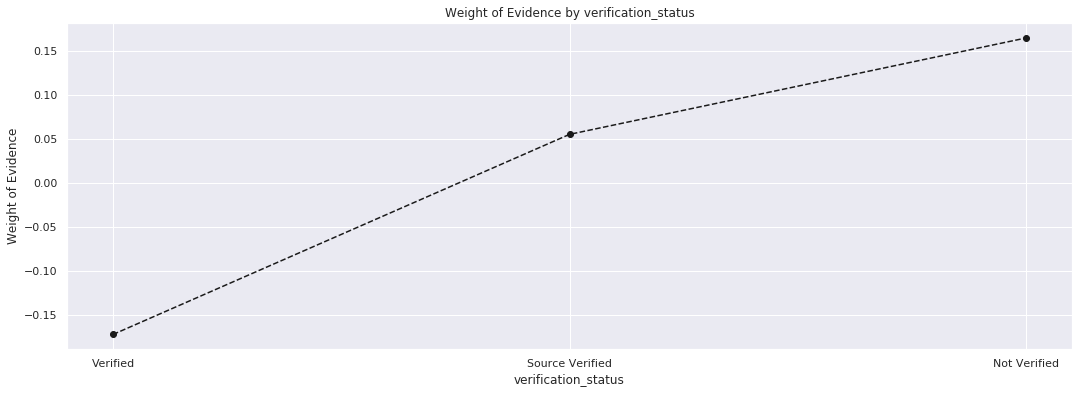

In [94]:
plot_by_woe(df_temp)

Keep original dummy variables for verification_status feature.

### purpose

In [95]:
df_inputs_prepr['purpose'].unique()

array(['debt_consolidation', 'educational', 'other', 'home_improvement',
       'credit_card', 'major_purchase', 'wedding', 'small_business',
       'vacation', 'house', 'car', 'moving', 'renewable_energy',
       'medical'], dtype=object)

In [96]:
df_temp = woe_discrete(df_inputs_prepr, 'purpose', df_targets_prepr)
df_temp

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,small_business,5582,0.786098,0.014964,4388.0,1194.0,0.013207,0.029280,-0.796180,NaN,NaN,0.035418
1,educational,333,0.801802,0.000893,267.0,66.0,0.000804,0.001619,-0.700151,0.015704,0.096029,0.035418
2,moving,2392,0.839465,0.006412,2008.0,384.0,0.006044,0.009417,-0.443493,0.037663,0.256658,0.035418
3,house,1830,0.860109,0.004906,1574.0,256.0,0.004737,0.006278,-0.281547,0.020644,0.161946,0.035418
4,other,18884,0.862264,0.050624,16283.0,2601.0,0.049008,0.063784,-0.263519,0.002155,0.018028,0.035418
5,renewable_energy,281,0.864769,0.000753,243.0,38.0,0.000731,0.000932,-0.242270,0.002504,0.021250,0.035418
6,medical,3684,0.868350,0.009876,3199.0,485.0,0.009628,0.011894,-0.211300,0.003581,0.030969,0.035418
7,wedding,1887,0.881823,0.005059,1664.0,223.0,0.005008,0.005469,-0.087937,0.013473,0.123363,0.035418
8,vacation,1991,0.882471,0.005337,1757.0,234.0,0.005288,0.005738,-0.081703,0.000648,0.006234,0.035418
9,debt_consolidation,219183,0.886884,0.587578,194390.0,24793.0,0.585071,0.607999,-0.038440,0.004413,0.043263,0.035418


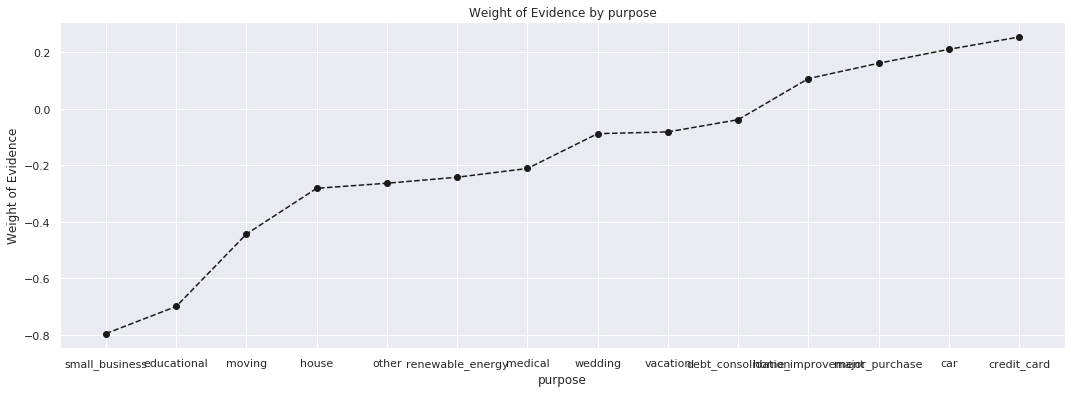

In [97]:
plot_by_woe(df_temp)

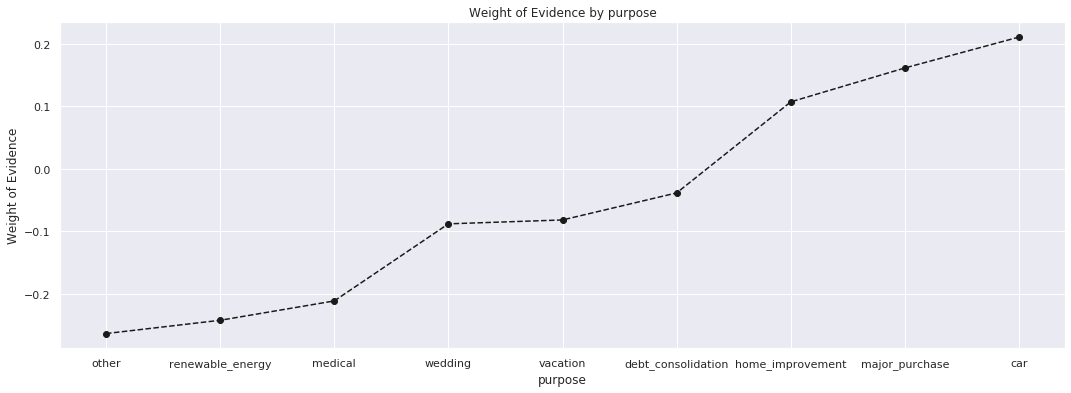

In [98]:
plot_by_woe(df_temp.iloc[4:-1, :])

In [99]:
# We combine 'educational', 'small_business', 'wedding', 'renewable_energy', 'moving', 'house' in one category: 'educ__sm_b__wedd__ren_en__mov__house'.
# We combine 'other', 'medical', 'vacation' in one category: 'oth__med__vacation'.
# We combine 'major_purchase', 'car', 'home_improvement' in one category: 'major_purch__car__home_impr'.
# We leave 'debt_consolidtion' in a separate category.
# We leave 'credit_card' in a separate category.
# 'educ__sm_b__wedd__ren_en__mov__house' will be the reference category.
df_inputs_prepr['purpose:educ__sm_b__wedd__ren_en__mov__house'] = sum([df_inputs_prepr['purpose:educational'], df_inputs_prepr['purpose:small_business'],
                                                                 df_inputs_prepr['purpose:wedding'], df_inputs_prepr['purpose:renewable_energy'],
                                                                 df_inputs_prepr['purpose:moving'], df_inputs_prepr['purpose:house']])
df_inputs_prepr['purpose:oth__med__vacation'] = sum([df_inputs_prepr['purpose:other'], df_inputs_prepr['purpose:medical'],
                                             df_inputs_prepr['purpose:vacation']])
df_inputs_prepr['purpose:major_purch__car__home_impr'] = sum([df_inputs_prepr['purpose:major_purchase'], df_inputs_prepr['purpose:car'],
                                                        df_inputs_prepr['purpose:home_improvement']])

In [100]:
# 'initial_list_status'
df_temp = woe_discrete(df_inputs_prepr, 'initial_list_status', df_targets_prepr)
df_temp

,initial_list_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,f,242514,0.879694,0.650123,213338.0,29176.0,0.642101,0.715484,-0.108214,NaN,NaN,0.02478
1,w,130514,0.911105,0.349877,118912.0,11602.0,0.357899,0.284516,0.229461,0.031412,0.337675,0.02478


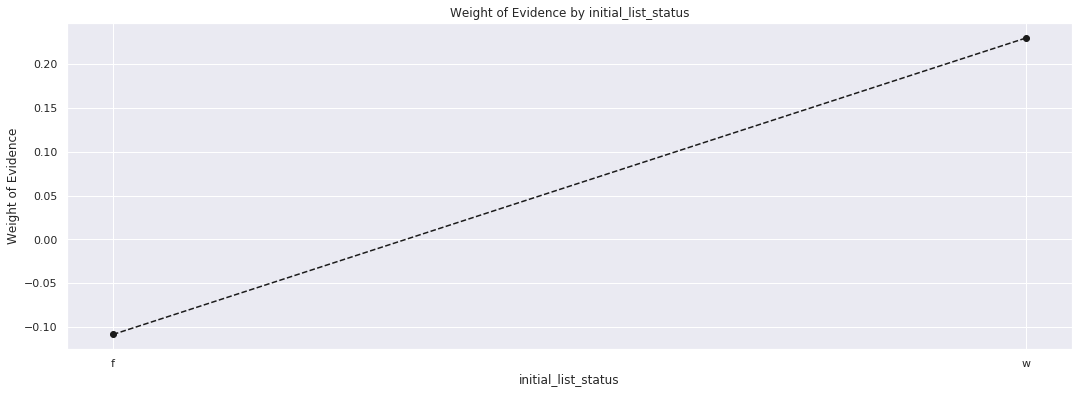

In [101]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

## Preprocessing Continuous Variables: Automating Calculations and Visualizing Results

In [48]:
# WoE function for ordered discrete and continuous variables
def woe_ordered_continuous(df, discrete_variabe_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df
# Here we define a function similar to the one above, ...
# ... with one slight difference: we order the results by the values of a different column.
# The function takes 3 arguments: a dataframe, a string, and a dataframe. The function returns a dataframe as a result.

## Preprocessing Continuous Variables: Creating Dummy Variables, Part 1

In [103]:
# term
df_inputs_prepr['term_int'].unique()
# There are only two unique values, 36 and 60.

array([36, 60])

In [104]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'term_int', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,term_int,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,36,270419,0.902995,0.724929,244187.0,26232.0,0.73495,0.643288,0.133209,NaN,NaN,0.039434
1,60,102609,0.858239,0.275071,88063.0,14546.0,0.26505,0.356712,-0.297009,0.044756,0.430218,0.039434


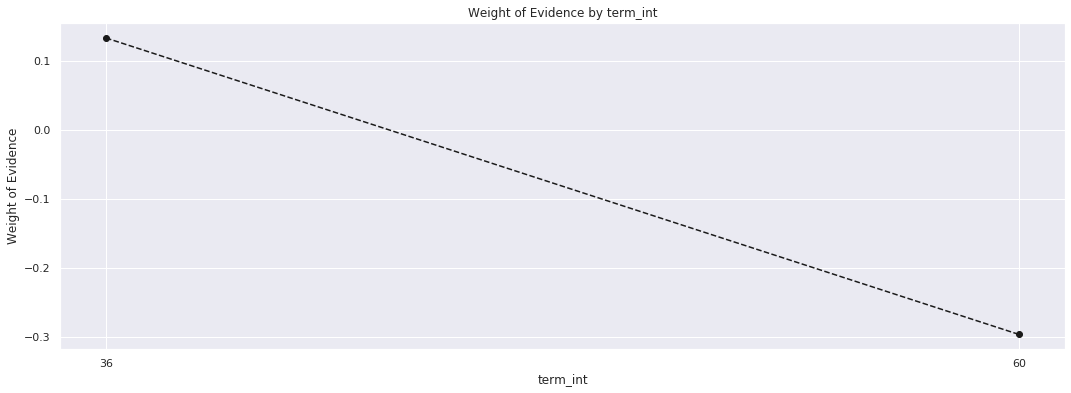

In [105]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [106]:
# Leave as is.
# '60' will be the reference category.
df_inputs_prepr['term:36'] = np.where((df_inputs_prepr['term_int'] == 36), 1, 0)
df_inputs_prepr['term:60'] = np.where((df_inputs_prepr['term_int'] == 60), 1, 0)

In [107]:
# emp_length_int
df_inputs_prepr['emp_length_int'].unique()
# Has only 11 levels: from 0 to 10. Hence, we turn it into a factor with 11 levels.

array([ 3,  6, 10,  7,  5,  0,  2,  9,  1,  8,  4])

In [108]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'emp_length_int', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,emp_length_int,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0,45720,0.876400,0.122565,40069.0,5651.0,0.120599,0.138580,-0.138975,NaN,NaN,0.006506
1,1,23654,0.886996,0.063411,20981.0,2673.0,0.063148,0.065550,-0.037329,0.010596,0.101645,0.006506
2,2,33078,0.890955,0.088674,29471.0,3607.0,0.088701,0.088455,0.002785,0.003959,0.040114,0.006506
3,3,29205,0.890772,0.078292,26015.0,3190.0,0.078299,0.078228,0.000907,0.000183,0.001878,0.006506
4,4,22468,0.890644,0.060231,20011.0,2457.0,0.060229,0.060253,-0.000404,0.000128,0.001311,0.006506
5,5,24602,0.884725,0.065952,21766.0,2836.0,0.065511,0.069547,-0.059790,0.005920,0.059387,0.006506
6,6,20887,0.883899,0.055993,18462.0,2425.0,0.055567,0.059468,-0.067862,0.000826,0.008071,0.006506
7,7,21049,0.887453,0.056427,18680.0,2369.0,0.056223,0.058095,-0.032759,0.003554,0.035102,0.006506
8,8,17853,0.889878,0.047860,15887.0,1966.0,0.047816,0.048212,-0.008245,0.002425,0.024515,0.006506
9,9,14267,0.886662,0.038246,12650.0,1617.0,0.038074,0.039654,-0.040660,0.003217,0.032416,0.006506


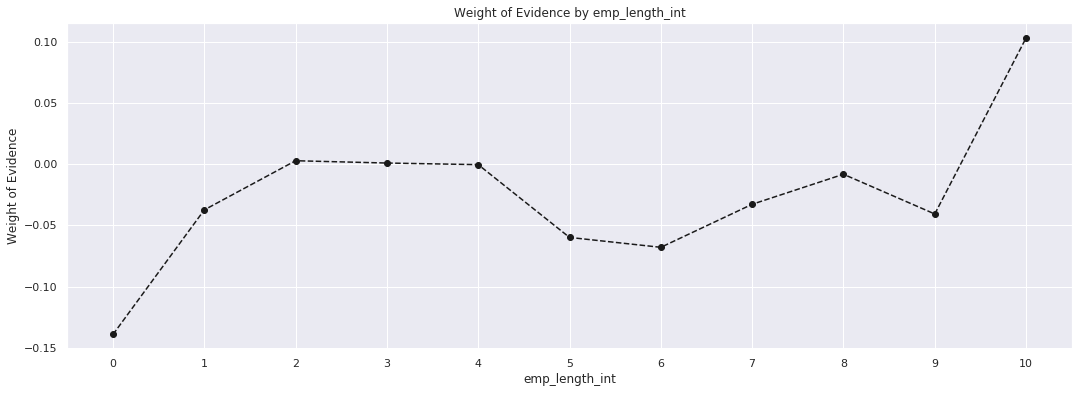

In [109]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [110]:
# We create the following categories: '0', '1', '2 - 4', '5 - 6', '7 - 9', '10'
# '0' will be the reference category
df_inputs_prepr['emp_length:0'] = np.where(df_inputs_prepr['emp_length_int'].isin([0]), 1, 0)
df_inputs_prepr['emp_length:1'] = np.where(df_inputs_prepr['emp_length_int'].isin([1]), 1, 0)
df_inputs_prepr['emp_length:2-4'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(2, 5)), 1, 0)
df_inputs_prepr['emp_length:5-6'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(5, 7)), 1, 0)
df_inputs_prepr['emp_length:7-9'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(7, 10)), 1, 0)
df_inputs_prepr['emp_length:10'] = np.where(df_inputs_prepr['emp_length_int'].isin([10]), 1, 0)

## Preprocessing Continuous Variables: Creating Dummy Variables, Part 2

In [111]:
df_inputs_prepr['mths_since_issue_d'].unique()

array([ 45.,  64.,  54.,  44., 101.,  37.,  91.,  53.,  42.,  57.,  58.,
        43.,  40.,  51.,  59., 113.,  50.,  62.,  49.,  47.,  48.,  41.,
        38.,  66.,  69.,  87.,  46.,  76.,  63.,  39.,  61.,  89.,  65.,
        56.,  79.,  68.,  52.,  60.,  73.,  74.,  70.,  88.,  81.,  82.,
        55., 103.,  83.,  72.,  85.,  36.,  71.,  92.,  77.,  67.,  84.,
        86.,  90., 116.,  93.,  95.,  78.,  75.,  80.,  96.,  94.,  98.,
       104., 125., 105., 118., 110., 119., 114.,  97., 102., 106., 100.,
       122., 121., 108., 117., 120., 124.,  99., 115., 112., 109., 123.,
       107., 126., 111.])

In [45]:
df_inputs_prepr['mths_since_issue_d_factor'] = pd.cut(df_inputs_prepr['mths_since_issue_d'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.

In [46]:
df_inputs_prepr['mths_since_issue_d_factor']

427211      (43.2, 45.0]
206088      (63.0, 64.8]
136020      (52.2, 54.0]
412305      (43.2, 45.0]
36159     (100.8, 102.6]
               ...      
259178     (35.91, 37.8]
365838      (41.4, 43.2]
131932      (52.2, 54.0]
146867      (55.8, 57.6]
121958      (52.2, 54.0]
Name: mths_since_issue_d_factor, Length: 373028, dtype: category
Categories (50, interval[float64]): [(35.91, 37.8] < (37.8, 39.6] < (39.6, 41.4] < (41.4, 43.2] ... (118.8, 120.6] < (120.6, 122.4] < (122.4, 124.2] < (124.2, 126.0]]

In [49]:
# mths_since_issue_d
df_temp = woe_ordered_continuous(df_inputs_prepr, 'mths_since_issue_d_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,mths_since_issue_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(35.91, 37.8]",28170,0.942244,0.075517,26543.0,1627.0,0.079889,0.039899,0.694283,NaN,NaN,0.113186
1,"(37.8, 39.6]",39636,0.928424,0.106255,36799.0,2837.0,0.110757,0.069572,0.464979,0.013820,0.229305,0.113186
2,"(39.6, 41.4]",38614,0.917284,0.103515,35420.0,3194.0,0.106606,0.078327,0.308258,0.011140,0.156721,0.113186
3,"(41.4, 43.2]",29038,0.908603,0.077844,26384.0,2654.0,0.079410,0.065084,0.198945,0.008681,0.109313,0.113186
4,"(43.2, 45.0]",28367,0.901787,0.076045,25581.0,2786.0,0.076993,0.068321,0.119498,0.006815,0.079447,0.113186
5,"(45.0, 46.8]",12165,0.899301,0.032611,10940.0,1225.0,0.032927,0.030041,0.091740,0.002486,0.027758,0.113186
6,"(46.8, 48.6]",24451,0.898900,0.065547,21979.0,2472.0,0.066152,0.060621,0.087315,0.000401,0.004425,0.113186
7,"(48.6, 50.4]",22969,0.888328,0.061574,20404.0,2565.0,0.061412,0.062902,-0.023972,0.010572,0.111287,0.113186
8,"(50.4, 52.2]",20640,0.880523,0.055331,18174.0,2466.0,0.054700,0.060474,-0.100350,0.007804,0.076378,0.113186
9,"(52.2, 54.0]",18312,0.866863,0.049090,15874.0,2438.0,0.047777,0.059787,-0.224240,0.013660,0.123890,0.113186


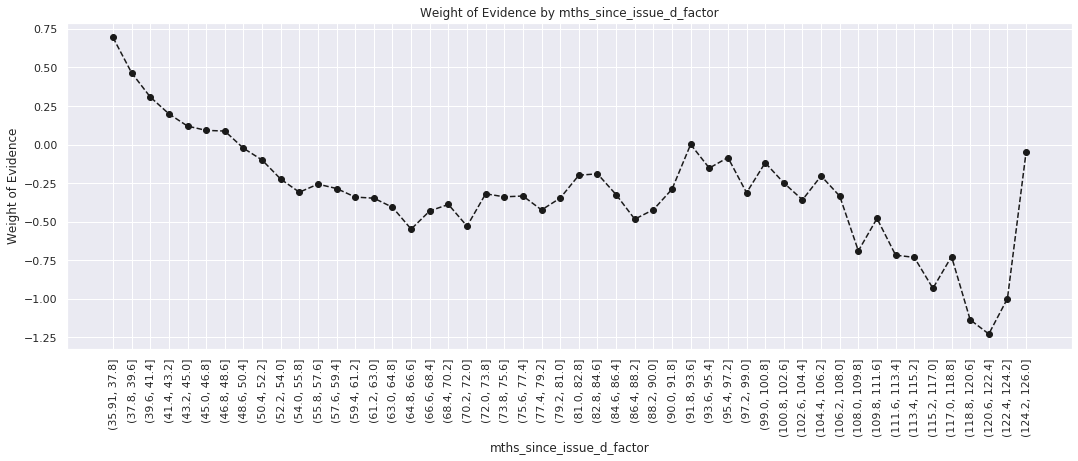

In [50]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.
# We have to rotate the labels because we cannot read them otherwise.

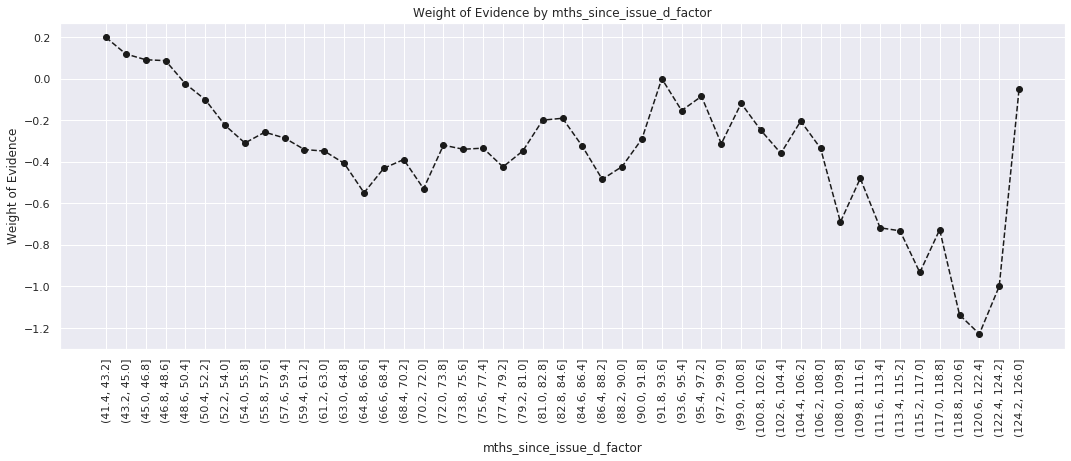

In [51]:
plot_by_woe(df_temp.iloc[3: , : ], 90)
# We plot the weight of evidence values.

In [52]:
# We create the following categories:
# < 38, 38 - 39, 40 - 41, 42 - 48, 49 - 52, 53 - 64, 65 - 84, > 84.
df_inputs_prepr['mths_since_issue_d:<38'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38)), 1, 0)
df_inputs_prepr['mths_since_issue_d:38-39'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38, 40)), 1, 0)
df_inputs_prepr['mths_since_issue_d:40-41'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(40, 42)), 1, 0)
df_inputs_prepr['mths_since_issue_d:42-48'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(42, 49)), 1, 0)
df_inputs_prepr['mths_since_issue_d:49-52'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(49, 53)), 1, 0)
df_inputs_prepr['mths_since_issue_d:53-64'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(53, 65)), 1, 0)
df_inputs_prepr['mths_since_issue_d:65-84'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(65, 85)), 1, 0)
df_inputs_prepr['mths_since_issue_d:>84'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(85, int(df_inputs_prepr['mths_since_issue_d'].max()))), 1, 0)

### int_rate: Interest Rate on the loan

In [53]:
# int_rate
df_inputs_prepr['int_rate_factor'] = pd.cut(df_inputs_prepr['int_rate'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.

In [54]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'int_rate_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.399, 5.833]",785,0.961783,0.002104,755.0,30.0,0.002272,0.000736,1.127775,NaN,NaN,0.343349
1,"(5.833, 6.246]",8459,0.980376,0.022677,8293.0,166.0,0.024960,0.004071,1.813434,0.018592,0.685659,0.343349
2,"(6.246, 6.658]",7826,0.971505,0.020980,7603.0,223.0,0.022883,0.005469,1.431381,0.008871,0.382053,0.343349
3,"(6.658, 7.071]",1816,0.973018,0.004868,1767.0,49.0,0.005318,0.001202,1.487473,0.001512,0.056092,0.343349
4,"(7.071, 7.484]",3143,0.976456,0.008426,3069.0,74.0,0.009237,0.001815,1.627297,0.003438,0.139824,0.343349
5,"(7.484, 7.897]",12581,0.962324,0.033727,12107.0,474.0,0.036439,0.011624,1.142587,0.014131,0.484710,0.343349
6,"(7.897, 8.31]",9687,0.949314,0.025969,9196.0,491.0,0.027678,0.012041,0.832335,0.013011,0.310252,0.343349
7,"(8.31, 8.722]",6594,0.965271,0.017677,6365.0,229.0,0.019157,0.005616,1.227103,0.015958,0.394768,0.343349
8,"(8.722, 9.135]",9539,0.937415,0.025572,8942.0,597.0,0.026913,0.014640,0.608852,0.027857,0.618250,0.343349
9,"(9.135, 9.548]",6681,0.963928,0.017910,6440.0,241.0,0.019383,0.005910,1.187742,0.026513,0.578889,0.343349


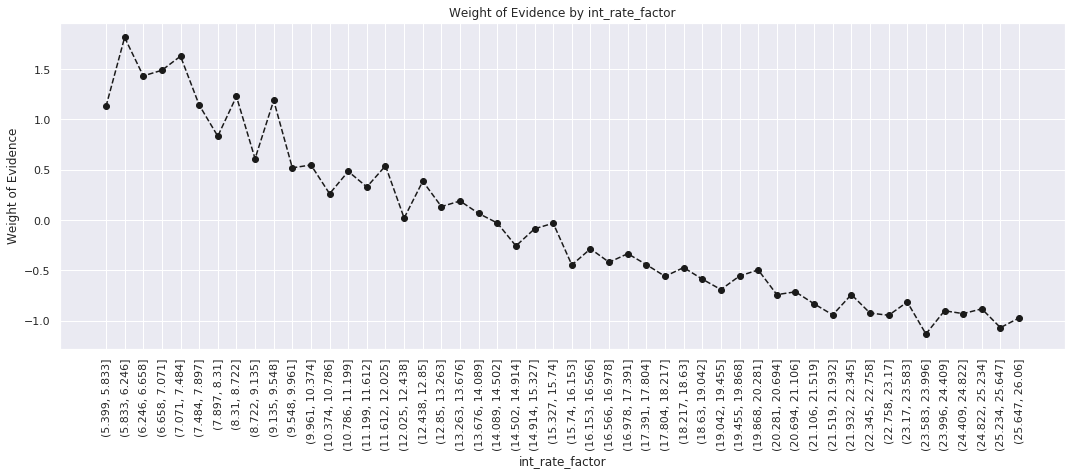

In [55]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [ ]:
# '< 9.548', '9.548 - 12.025', '12.025 - 15.74', '15.74 - 20.281', '> 20.281'
df_inputs_prepr['int_rate:<9.548'] = np.where((df_inputs_prepr['int_rate'] <= 9.548), 1, 0)
df_inputs_prepr['int_rate:9.548-12.025'] = np.where((df_inputs_prepr['int_rate'] > 9.548) & (df_inputs_prepr['int_rate'] <= 12.025), 1, 0)
df_inputs_prepr['int_rate:12.025-15.74'] = np.where((df_inputs_prepr['int_rate'] > 12.025) & (df_inputs_prepr['int_rate'] <= 15.74), 1, 0)
df_inputs_prepr['int_rate:15.74-20.281'] = np.where((df_inputs_prepr['int_rate'] > 15.74) & (df_inputs_prepr['int_rate'] <= 20.281), 1, 0)
df_inputs_prepr['int_rate:>20.281'] = np.where((df_inputs_prepr['int_rate'] > 20.281), 1, 0)

In [56]:
# funded_amnt
df_inputs_prepr['funded_amnt_factor'] = pd.cut(df_inputs_prepr['funded_amnt'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'funded_amnt_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,funded_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(465.5, 1190.0]",1224,0.905229,0.003281,1108.0,116.0,0.003335,0.002845,0.158977,NaN,NaN,0.014139
1,"(1190.0, 1880.0]",3028,0.903897,0.008117,2737.0,291.0,0.008238,0.007136,0.143549,0.001332,0.015427,0.014139
2,"(1880.0, 2570.0]",6018,0.893819,0.016133,5379.0,639.0,0.016190,0.015670,0.032608,0.010078,0.110941,0.014139
3,"(2570.0, 3260.0]",7248,0.889073,0.019430,6444.0,804.0,0.019395,0.019717,-0.016440,0.004746,0.049048,0.014139
4,"(3260.0, 3950.0]",4751,0.891602,0.012736,4236.0,515.0,0.012749,0.012629,0.009463,0.002529,0.025902,0.014139
5,"(3950.0, 4640.0]",9023,0.890945,0.024189,8039.0,984.0,0.024196,0.024131,0.002689,0.000656,0.006774,0.014139
6,"(4640.0, 5330.0]",15903,0.892159,0.042632,14188.0,1715.0,0.042703,0.042057,0.015238,0.001213,0.012549,0.014139
7,"(5330.0, 6020.0]",17236,0.906069,0.046206,15617.0,1619.0,0.047004,0.039703,0.168806,0.013910,0.153568,0.014139
8,"(6020.0, 6710.0]",6914,0.887619,0.018535,6137.0,777.0,0.018471,0.019054,-0.031094,0.018449,0.199900,0.014139
9,"(6710.0, 7400.0]",11806,0.898018,0.031649,10602.0,1204.0,0.031910,0.029526,0.077648,0.010399,0.108742,0.014139


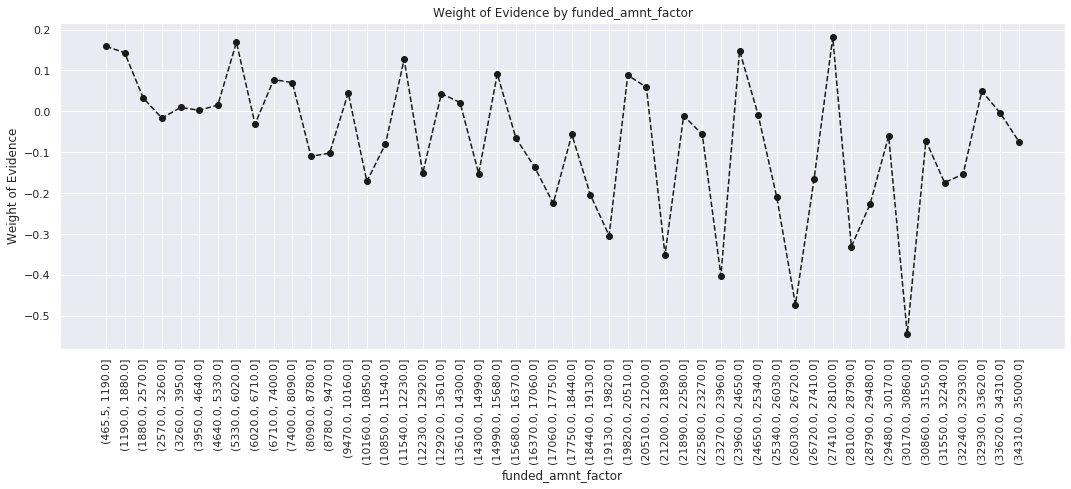

In [57]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

<li> mths_since_earliest_cr_line
<li> installment: The monthly payment owed by the borrower if the loan originates.
<li> delinq_2yrs: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
<li> inq_last_6mths: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
<li> open_acc
<li> pub_rec: Number of derogatory public records
<li> total_acc
<li> acc_now_delinq: The number of accounts on which the borrower is now delinquent.

In [58]:
df_inputs_prepr['mths_since_earliest_cr_line_factor'] =pd.cut(df_inputs_prepr['mths_since_earliest_cr_line'], 50)

In [59]:
df_temp = woe_ordered_continuous(df_inputs_prepr,'mths_since_earliest_cr_line_factor',df_targets_prepr) 
df_temp

,mths_since_earliest_cr_line_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.587, 11.74]",24,0.875000,0.000064,21.0,3.0,0.000063,0.000074,-0.151835,NaN,NaN,0.016273
1,"(11.74, 23.48]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016273
2,"(23.48, 35.22]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016273
3,"(35.22, 46.96]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016273
4,"(46.96, 58.7]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016273
5,"(58.7, 70.44]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016273
6,"(70.44, 82.18]",722,0.898892,0.001936,649.0,73.0,0.001953,0.001790,0.087228,NaN,NaN,0.016273
7,"(82.18, 93.92]",1929,0.884914,0.005171,1707.0,222.0,0.005138,0.005444,-0.057930,0.013978,0.145158,0.016273
8,"(93.92, 105.66]",2817,0.857295,0.007552,2415.0,402.0,0.007269,0.009858,-0.304742,0.027619,0.246813,0.016273
9,"(105.66, 117.4]",5092,0.871170,0.013650,4436.0,656.0,0.013351,0.016087,-0.186397,0.013875,0.118345,0.016273


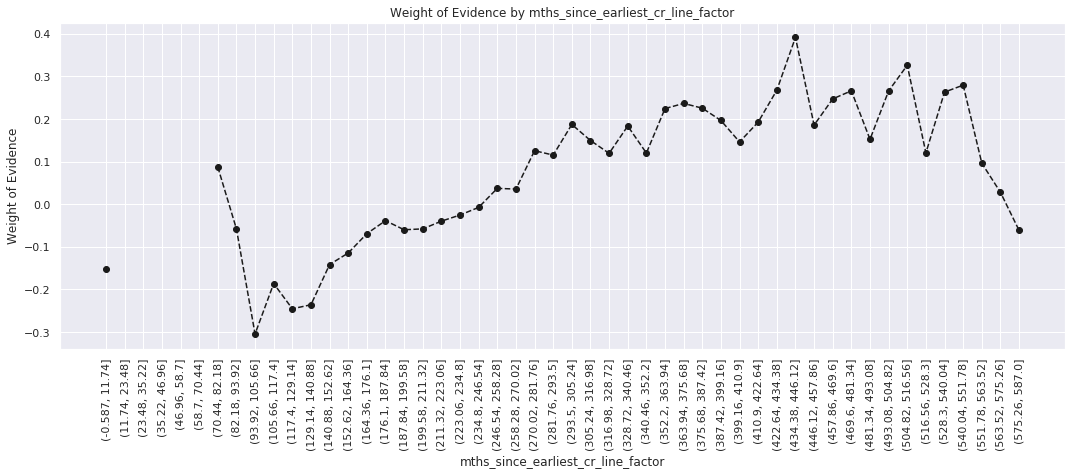

In [60]:
plot_by_woe(df_temp, 90)

In [ ]:
# We create the following categories:
# < 140, # 141 - 164, # 165 - 247, # 248 - 270, # 271 - 352, # > 352
df_inputs_prepr['mths_since_earliest_cr_line:<140'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(140)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:141-164'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(140, 165)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:165-247'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(165, 248)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:248-270'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(248, 271)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:271-352'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(271, 353)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:>352'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(353, int(df_inputs_prepr['mths_since_earliest_cr_line'].max()))), 1, 0)

In [61]:
# delinq_2yrs
df_temp = woe_ordered_continuous(df_inputs_prepr, 'delinq_2yrs', df_targets_prepr)
# We calculate weight of evidence.
df_temp

/opt/conda/lib/python3.7/site-packages/pandas/core/algorithms.py:1926: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,delinq_2yrs,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,306417,0.890499,0.821432,272864.0,33553.0,0.821261,0.822821,-0.001898,NaN,NaN,inf
1,1.0,44927,0.893249,0.120439,40131.0,4796.0,0.120786,0.117612,0.026622,0.002750,0.028520,inf
2,2.0,13118,0.889007,0.035166,11662.0,1456.0,0.035100,0.035706,-0.017102,0.004242,0.043724,inf
3,3.0,4550,0.883297,0.012197,4019.0,531.0,0.012096,0.013022,-0.073719,0.005711,0.056616,inf
4,4.0,1868,0.898822,0.005008,1679.0,189.0,0.005053,0.004635,0.086462,0.015526,0.160180,inf
5,5.0,966,0.881988,0.002590,852.0,114.0,0.002564,0.002796,-0.086357,0.016835,0.172819,inf
6,6.0,501,0.902196,0.001343,452.0,49.0,0.001360,0.001202,0.124117,0.020208,0.210474,inf
7,7.0,279,0.860215,0.000748,240.0,39.0,0.000722,0.000956,-0.280668,0.041981,0.404785,inf
8,8.0,148,0.905405,0.000397,134.0,14.0,0.000403,0.000343,0.161037,0.045190,0.441705,inf
9,9.0,89,0.887640,0.000239,79.0,10.0,0.000238,0.000245,-0.030882,0.017765,0.191920,inf


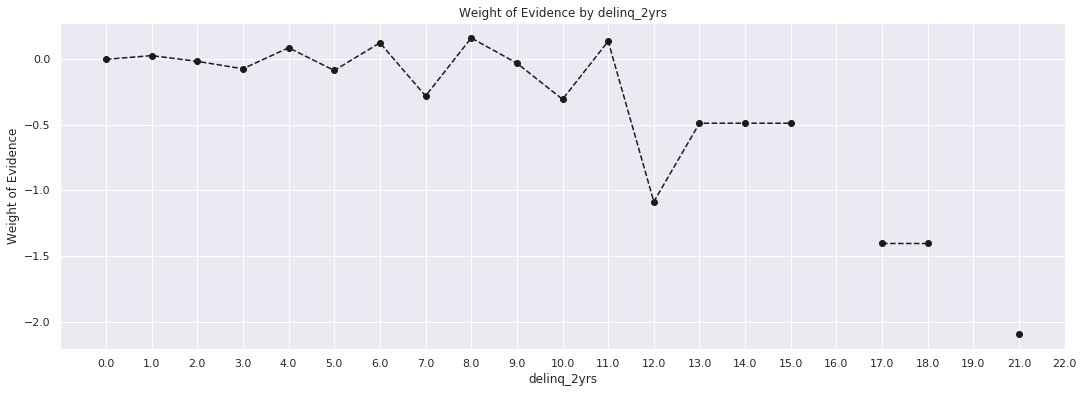

In [62]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [ ]:
# Categories: 0, 1-3, >=4
df_inputs_prepr['delinq_2yrs:0'] = np.where((df_inputs_prepr['delinq_2yrs'] == 0), 1, 0)
df_inputs_prepr['delinq_2yrs:1-3'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 1) & (df_inputs_prepr['delinq_2yrs'] <= 3), 1, 0)
df_inputs_prepr['delinq_2yrs:>=4'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 9), 1, 0)

In [63]:
# inq_last_6mths
df_temp = woe_ordered_continuous(df_inputs_prepr, 'inq_last_6mths', df_targets_prepr)
# We calculate weight of evidence.
df_temp

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/core/algorithms.py:1926: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,inq_last_6mths,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,193232,0.908395,0.518009,175531.0,17701.0,0.528310,0.434082,0.196450,NaN,NaN,inf
1,1.0,104163,0.884950,0.279236,92179.0,11984.0,0.277439,0.293884,-0.057585,0.023446,0.254035,inf
2,2.0,46214,0.864197,0.123889,39938.0,6276.0,0.120205,0.153907,-0.247150,0.020753,0.189564,inf
3,3.0,20040,0.839671,0.053723,16827.0,3213.0,0.050646,0.078792,-0.441965,0.024526,0.194816,inf
4,4.0,5810,0.848365,0.015575,4929.0,881.0,0.014835,0.021605,-0.375911,0.008694,0.066054,inf
5,5.0,2217,0.824989,0.005943,1829.0,388.0,0.005505,0.009515,-0.547226,0.023376,0.171314,inf
6,6.0,977,0.788127,0.002619,770.0,207.0,0.002318,0.005076,-0.784073,0.036862,0.236848,inf
7,7.0,159,0.679245,0.000426,108.0,51.0,0.000325,0.001251,-1.347439,0.108882,0.563366,inf
8,8.0,101,0.643564,0.000271,65.0,36.0,0.000196,0.000883,-1.506877,0.035681,0.159437,inf
9,9.0,43,0.674419,0.000115,29.0,14.0,0.000087,0.000343,-1.369506,0.030854,0.137370,inf


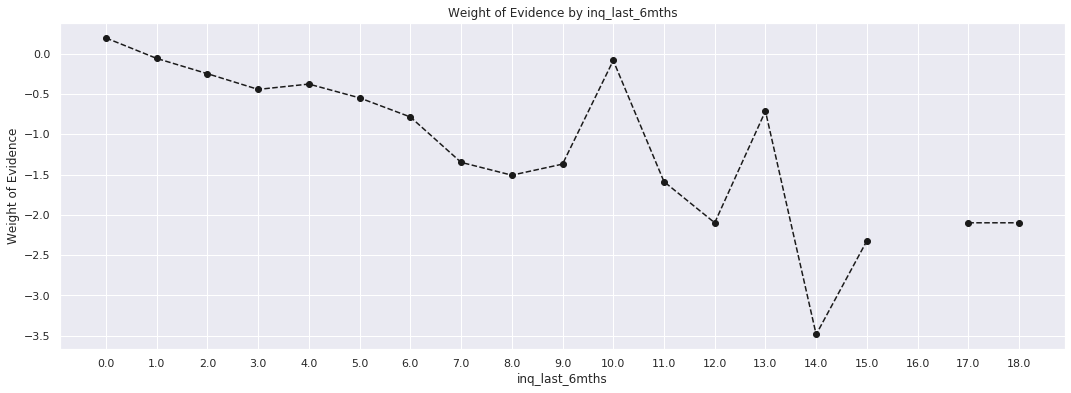

In [64]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [ ]:
# Categories: 0, 1 - 2, 3 - 6, > 6
df_inputs_prepr['inq_last_6mths:0'] = np.where((df_inputs_prepr['inq_last_6mths'] == 0), 1, 0)
df_inputs_prepr['inq_last_6mths:1-2'] = np.where((df_inputs_prepr['inq_last_6mths'] >= 1) & (df_inputs_prepr['inq_last_6mths'] <= 2), 1, 0)
df_inputs_prepr['inq_last_6mths:3-6'] = np.where((df_inputs_prepr['inq_last_6mths'] >= 3) & (df_inputs_prepr['inq_last_6mths'] <= 6), 1, 0)
df_inputs_prepr['inq_last_6mths:>6'] = np.where((df_inputs_prepr['inq_last_6mths'] > 6), 1, 0)

In [65]:
# open_acc
df_temp = woe_ordered_continuous(df_inputs_prepr, 'open_acc', df_targets_prepr)
# We calculate weight of evidence.
df_temp

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/core/algorithms.py:1926: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,open_acc,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,29,0.758621,0.000078,22.0,7.0,0.000066,0.000172,-0.952613,NaN,NaN,inf
1,1.0,110,0.872727,0.000295,96.0,14.0,0.000289,0.000343,-0.172454,0.114107,0.780159,inf
2,2.0,1456,0.845467,0.003903,1231.0,225.0,0.003705,0.005518,-0.398263,0.027260,0.225809,inf
3,3.0,4378,0.873687,0.011736,3825.0,553.0,0.011512,0.013561,-0.163789,0.028220,0.234474,inf
4,4.0,10028,0.891504,0.026883,8940.0,1088.0,0.026907,0.026681,0.008449,0.017817,0.172239,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
56,58.0,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,0.000000,NaN,inf
57,62.0,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,0.000000,NaN,inf
58,75.0,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,0.000000,NaN,inf
59,76.0,2,0.000000,0.000005,0.0,2.0,0.000000,0.000049,-inf,1.000000,inf,inf


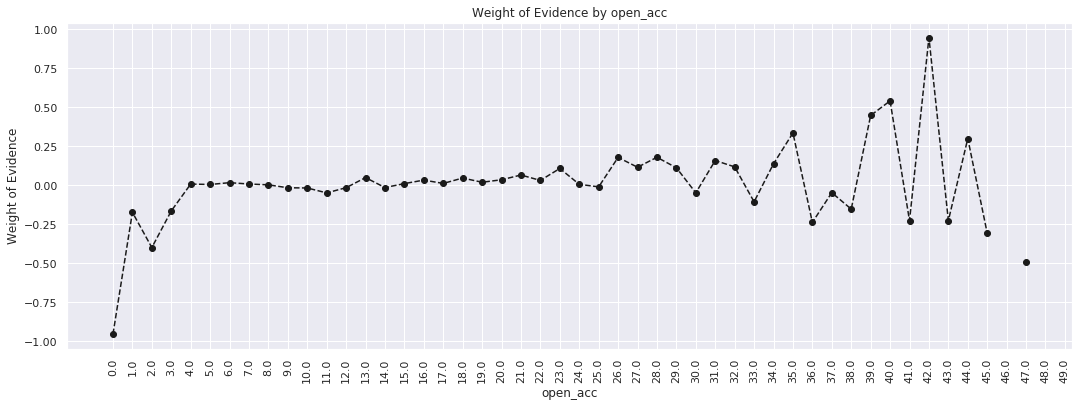

In [66]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

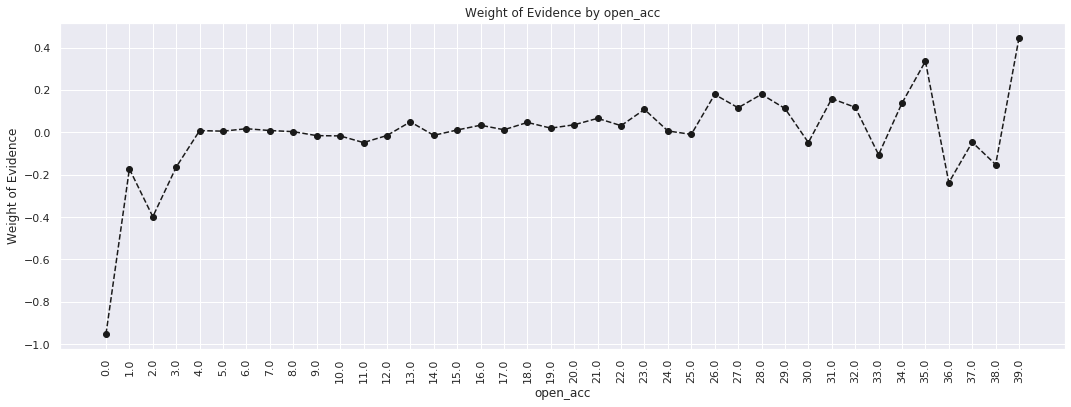

In [67]:
plot_by_woe(df_temp.iloc[ : 40, :], 90)
# We plot the weight of evidence values.

In [ ]:
# Categories: '0', '1-3', '4-12', '13-17', '18-22', '23-25', '26-30', '>30'
df_inputs_prepr['open_acc:0'] = np.where((df_inputs_prepr['open_acc'] == 0), 1, 0)
df_inputs_prepr['open_acc:1-3'] = np.where((df_inputs_prepr['open_acc'] >= 1) & (df_inputs_prepr['open_acc'] <= 3), 1, 0)
df_inputs_prepr['open_acc:4-12'] = np.where((df_inputs_prepr['open_acc'] >= 4) & (df_inputs_prepr['open_acc'] <= 12), 1, 0)
df_inputs_prepr['open_acc:13-17'] = np.where((df_inputs_prepr['open_acc'] >= 13) & (df_inputs_prepr['open_acc'] <= 17), 1, 0)
df_inputs_prepr['open_acc:18-22'] = np.where((df_inputs_prepr['open_acc'] >= 18) & (df_inputs_prepr['open_acc'] <= 22), 1, 0)
df_inputs_prepr['open_acc:23-25'] = np.where((df_inputs_prepr['open_acc'] >= 23) & (df_inputs_prepr['open_acc'] <= 25), 1, 0)
df_inputs_prepr['open_acc:26-30'] = np.where((df_inputs_prepr['open_acc'] >= 26) & (df_inputs_prepr['open_acc'] <= 30), 1, 0)
df_inputs_prepr['open_acc:>=31'] = np.where((df_inputs_prepr['open_acc'] >= 31), 1, 0)

In [68]:
# pub_rec
df_temp = woe_ordered_continuous(df_inputs_prepr, 'pub_rec', df_targets_prepr)
# We calculate weight of evidence.
df_temp

/opt/conda/lib/python3.7/site-packages/pandas/core/algorithms.py:1926: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,pub_rec,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,323999,0.889941,0.868565,288340.0,35659.0,0.867840,0.874467,-0.007606,NaN,NaN,inf
1,1.0,42381,0.893419,0.113613,37864.0,4517.0,0.113962,0.110771,0.028408,0.003478,0.036014,inf
2,2.0,4527,0.903247,0.012136,4089.0,438.0,0.012307,0.010741,0.136092,0.009828,0.107684,inf
3,3.0,1280,0.920312,0.003431,1178.0,102.0,0.003546,0.002501,0.348856,0.017065,0.212764,inf
4,4.0,408,0.924020,0.001094,377.0,31.0,0.001135,0.000760,0.400513,0.003707,0.051657,inf
5,5.0,203,0.911330,0.000544,185.0,18.0,0.000557,0.000441,0.232239,0.012690,0.168274,inf
6,6.0,117,0.931624,0.000314,109.0,8.0,0.000328,0.000196,0.514161,0.020294,0.281922,inf
7,7.0,48,0.958333,0.000129,46.0,2.0,0.000138,0.000049,1.037749,0.026709,0.523588,inf
8,8.0,24,1.000000,0.000064,24.0,0.0,0.000072,0.000000,inf,0.041667,inf,inf
9,9.0,14,0.785714,0.000038,11.0,3.0,0.000033,0.000074,-0.798462,0.214286,inf,inf


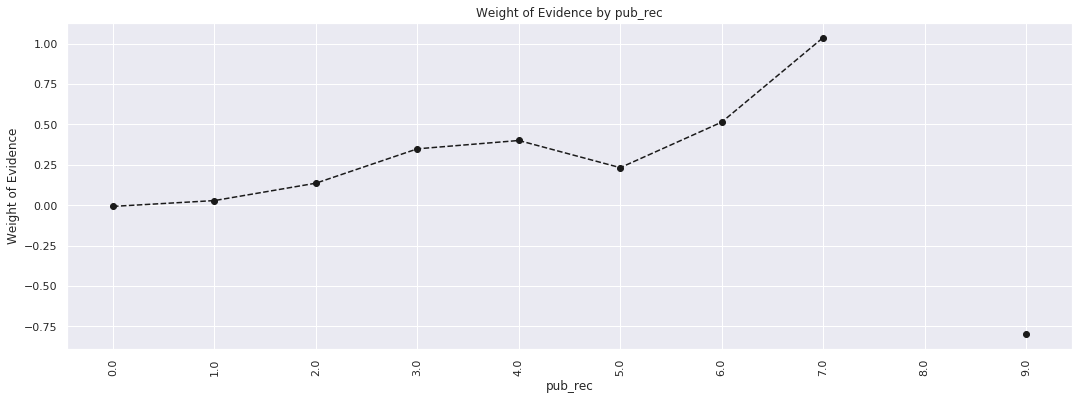

In [69]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [ ]:
# Categories '0-2', '3-4', '>=5'
df_inputs_prepr['pub_rec:0-2'] = np.where((df_inputs_prepr['pub_rec'] >= 0) & (df_inputs_prepr['pub_rec'] <= 2), 1, 0)
df_inputs_prepr['pub_rec:3-4'] = np.where((df_inputs_prepr['pub_rec'] >= 3) & (df_inputs_prepr['pub_rec'] <= 4), 1, 0)
df_inputs_prepr['pub_rec:>=5'] = np.where((df_inputs_prepr['pub_rec'] >= 5), 1, 0)

In [70]:
# total_acc
df_inputs_prepr['total_acc_factor'] = pd.cut(df_inputs_prepr['total_acc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'total_acc_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

/opt/conda/lib/python3.7/site-packages/pandas/core/algorithms.py:1926: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,total_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.15, 3.0]",459,0.810458,0.001230,372.0,87.0,0.001120,0.002134,-0.644759,NaN,NaN,inf
1,"(3.0, 6.0]",6004,0.864757,0.016095,5192.0,812.0,0.015627,0.019913,-0.242371,0.054299,0.402388,inf
2,"(6.0, 9.0]",15047,0.873131,0.040337,13138.0,1909.0,0.039543,0.046814,-0.168816,0.008374,0.073555,inf
3,"(9.0, 12.0]",25169,0.881283,0.067472,22181.0,2988.0,0.066760,0.073275,-0.093113,0.008152,0.075703,inf
4,"(12.0, 15.0]",33651,0.881281,0.090210,29656.0,3995.0,0.089258,0.097969,-0.093124,0.000001,0.000011,inf
5,"(15.0, 18.0]",38711,0.887267,0.103775,34347.0,4364.0,0.103377,0.107018,-0.034619,0.005986,0.058505,inf
6,"(18.0, 21.0]",40599,0.886155,0.108836,35977.0,4622.0,0.108283,0.113345,-0.045693,0.001112,0.011073,inf
7,"(21.0, 24.0]",40163,0.891492,0.107668,35805.0,4358.0,0.107765,0.106871,0.008329,0.005337,0.054022,inf
8,"(24.0, 27.0]",36286,0.895442,0.097274,32492.0,3794.0,0.097794,0.093040,0.049828,0.003950,0.041499,inf
9,"(27.0, 30.0]",31775,0.899103,0.085181,28569.0,3206.0,0.085986,0.078621,0.089553,0.003661,0.039725,inf


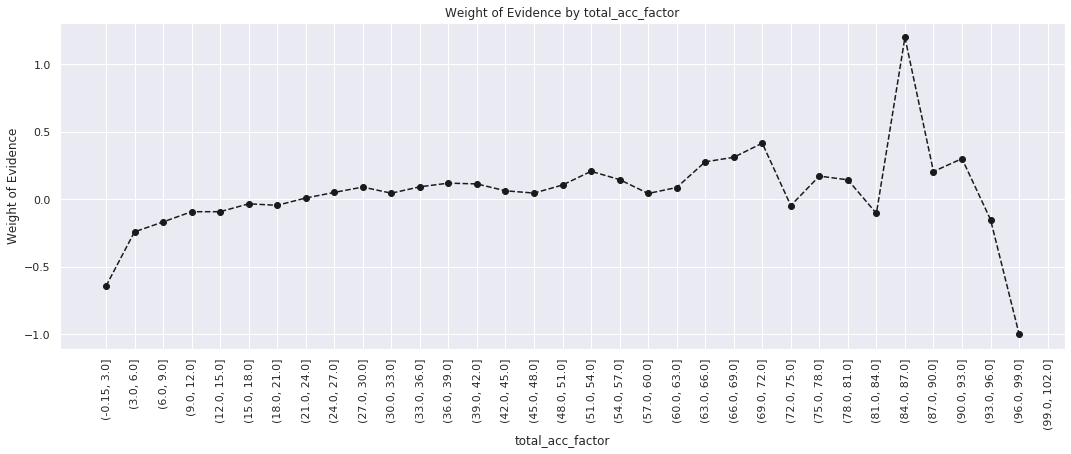

In [71]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [ ]:
# Categories: '<=27', '28-51', '>51'
df_inputs_prepr['total_acc:<=27'] = np.where((df_inputs_prepr['total_acc'] <= 27), 1, 0)
df_inputs_prepr['total_acc:28-51'] = np.where((df_inputs_prepr['total_acc'] >= 28) & (df_inputs_prepr['total_acc'] <= 51), 1, 0)
df_inputs_prepr['total_acc:>=52'] = np.where((df_inputs_prepr['total_acc'] >= 52), 1, 0)

In [72]:
# acc_now_delinq
df_temp = woe_ordered_continuous(df_inputs_prepr, 'acc_now_delinq', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,acc_now_delinq,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,371682,0.890648,0.996392,331038.0,40644.0,0.996352,0.996714,-0.000363,NaN,NaN,inf
1,1.0,1263,0.899446,0.003386,1136.0,127.0,0.003419,0.003114,0.093337,0.008797,0.093700,inf
2,2.0,70,0.928571,0.000188,65.0,5.0,0.000196,0.000123,0.467204,0.029126,0.373868,inf
3,3.0,7,0.857143,0.000019,6.0,1.0,0.000018,0.000025,-0.305986,0.071429,0.773190,inf
4,4.0,4,1.000000,0.000011,4.0,0.0,0.000012,0.000000,inf,0.142857,inf,inf
5,5.0,2,0.500000,0.000005,1.0,1.0,0.000003,0.000025,-2.097745,0.500000,inf,inf


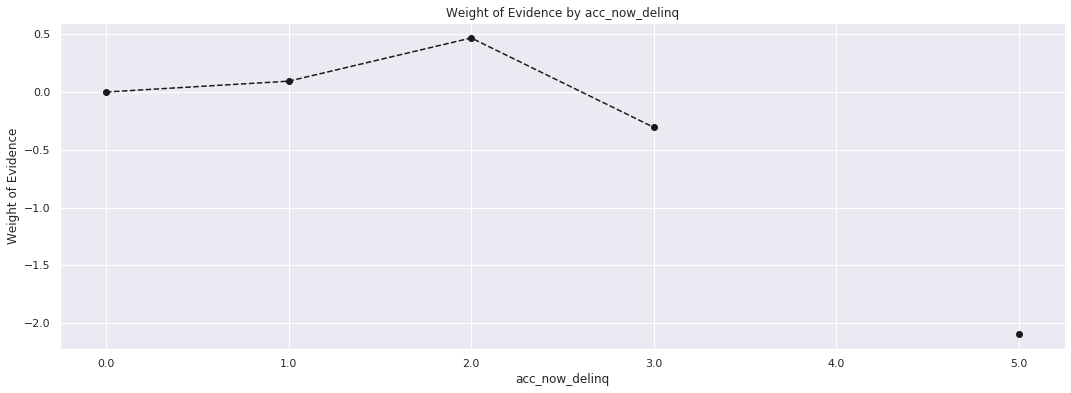

In [73]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [ ]:
# Categories: '0', '>=1'
df_inputs_prepr['acc_now_delinq:0'] = np.where((df_inputs_prepr['acc_now_delinq'] == 0), 1, 0)
df_inputs_prepr['acc_now_delinq:>=1'] = np.where((df_inputs_prepr['acc_now_delinq'] >= 1), 1, 0)

In [74]:
# total_rev_hi_lim
df_inputs_prepr['total_rev_hi_lim_factor'] = pd.cut(df_inputs_prepr['total_rev_hi_lim'], 2000)
# Here we do fine-classing: using the 'cut' method, we split the variable into 2000 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'total_rev_hi_lim_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/core/algorithms.py:1926: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,total_rev_hi_lim_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-9999.999, 5000.0]",19417,0.866457,0.052052,16824.0,2593.0,0.050637,0.063588,-0.227754,NaN,NaN,inf
1,"(5000.0, 9999.999]",52655,0.876194,0.141156,46136.0,6519.0,0.138859,0.159866,-0.140872,0.009737,0.086882,inf
2,"(9999.999, 14999.998]",59570,0.880376,0.159693,52444.0,7126.0,0.157845,0.174751,-0.101749,0.004182,0.039123,inf
3,"(14999.998, 19999.998]",51455,0.877582,0.137939,45156.0,6299.0,0.135910,0.154471,-0.128013,0.002794,0.026264,inf
4,"(19999.998, 24999.997]",41582,0.885792,0.111472,36833.0,4749.0,0.110859,0.116460,-0.049285,0.008210,0.078728,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,"(9974999.002, 9979999.002]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1996,"(9979999.002, 9984999.002]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1997,"(9984999.002, 9989999.001]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1998,"(9989999.001, 9994999.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


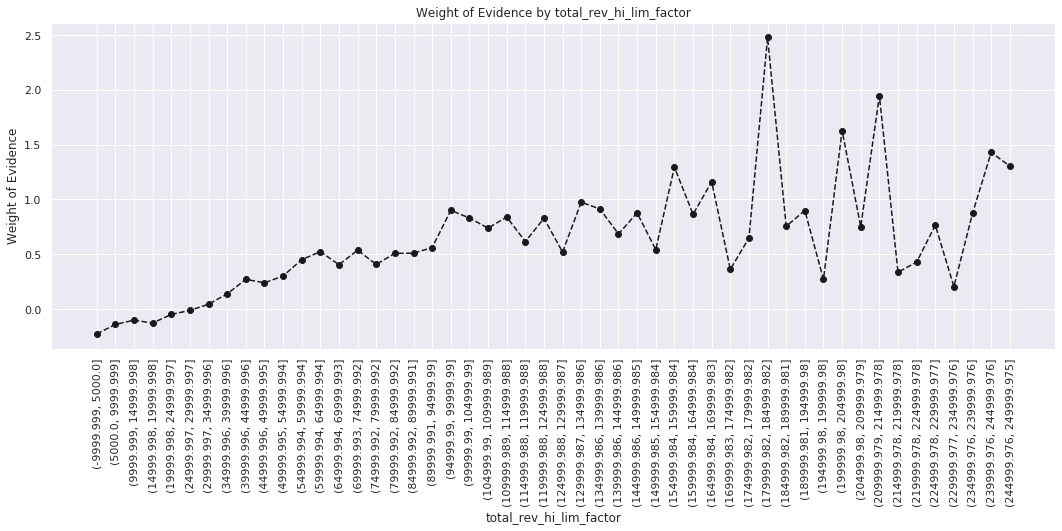

In [75]:
plot_by_woe(df_temp.iloc[: 50, : ], 90)
# We plot the weight of evidence values.

In [ ]:
# Categories
# '<=5K', '5K-10K', '10K-20K', '20K-30K', '30K-40K', '40K-55K', '55K-95K', '>95K'
df_inputs_prepr['total_rev_hi_lim:<=5K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] <= 5000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:5K-10K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 5000) & (df_inputs_prepr['total_rev_hi_lim'] <= 10000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:10K-20K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 10000) & (df_inputs_prepr['total_rev_hi_lim'] <= 20000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:20K-30K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 20000) & (df_inputs_prepr['total_rev_hi_lim'] <= 30000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:30K-40K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 30000) & (df_inputs_prepr['total_rev_hi_lim'] <= 40000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:40K-55K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 40000) & (df_inputs_prepr['total_rev_hi_lim'] <= 55000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:55K-95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 55000) & (df_inputs_prepr['total_rev_hi_lim'] <= 95000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:>95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 95000), 1, 0)

In [76]:
# installment
df_inputs_prepr['installment_factor'] = pd.cut(df_inputs_prepr['installment'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'installment_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,installment_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(14.276, 43.556]",1812,0.906181,0.004858,1642.0,170.0,0.004942,0.004169,0.170127,NaN,NaN,0.013497
1,"(43.556, 71.443]",4841,0.897542,0.012978,4345.0,496.0,0.013078,0.012163,0.072460,0.008639,0.097667,0.013497
2,"(71.443, 99.329]",6824,0.893025,0.018294,6094.0,730.0,0.018342,0.017902,0.024270,0.004517,0.048190,0.013497
3,"(99.329, 127.216]",9138,0.890348,0.024497,8136.0,1002.0,0.024488,0.024572,-0.003444,0.002677,0.027715,0.013497
4,"(127.216, 155.102]",10040,0.896514,0.026915,9001.0,1039.0,0.027091,0.025479,0.061332,0.006166,0.064776,0.013497
5,"(155.102, 182.988]",16816,0.894208,0.045080,15037.0,1779.0,0.045258,0.043626,0.036717,0.002306,0.024615,0.013497
6,"(182.988, 210.875]",17216,0.904798,0.046152,15577.0,1639.0,0.046883,0.040193,0.153964,0.010590,0.117247,0.013497
7,"(210.875, 238.761]",15090,0.900398,0.040453,13587.0,1503.0,0.040894,0.036858,0.103905,0.004400,0.050059,0.013497
8,"(238.761, 266.648]",18842,0.901391,0.050511,16984.0,1858.0,0.051118,0.045564,0.115026,0.000993,0.011121,0.013497
9,"(266.648, 294.534]",20100,0.891095,0.053883,17911.0,2189.0,0.053908,0.053681,0.004225,0.010296,0.110801,0.013497


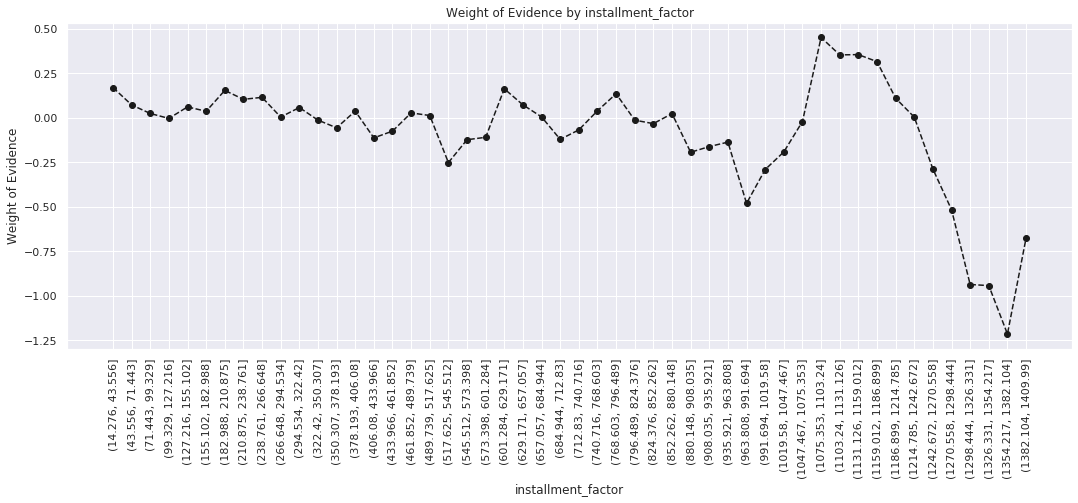

In [77]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

## Preprocessing Continuous Variables: Creating Dummy Variables, Part 3

In [78]:
# annual_inc
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'annual_inc_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

/opt/conda/lib/python3.7/site-packages/pandas/core/algorithms.py:1926: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-5243.882, 144693.64]",351904,0.888566,0.943372,312690.0,39214.0,0.941129,0.961646,-0.021567,NaN,NaN,inf
1,"(144693.64, 287491.28]",19004,0.925437,0.050945,17587.0,1417.0,0.052933,0.034749,0.420873,0.036871,0.442440,inf
2,"(287491.28, 430288.92]",1525,0.930492,0.004088,1419.0,106.0,0.004271,0.002599,0.496524,0.005055,0.075651,inf
3,"(430288.92, 573086.56]",332,0.939759,0.000890,312.0,20.0,0.000939,0.000490,0.649526,0.009267,0.153002,inf
4,"(573086.56, 715884.2]",112,0.883929,0.000300,99.0,13.0,0.000298,0.000319,-0.067574,0.055830,0.717100,inf
5,"(715884.2, 858681.84]",65,0.892308,0.000174,58.0,7.0,0.000175,0.000172,0.016788,0.008379,0.084362,inf
6,"(858681.84, 1001479.48]",39,0.974359,0.000105,38.0,1.0,0.000114,0.000025,1.539841,0.082051,1.523053,inf
7,"(1001479.48, 1144277.12]",10,1.000000,0.000027,10.0,0.0,0.000030,0.000000,inf,0.025641,inf,inf
8,"(1144277.12, 1287074.76]",12,1.000000,0.000032,12.0,0.0,0.000036,0.000000,inf,0.000000,NaN,inf
9,"(1287074.76, 1429872.4]",6,1.000000,0.000016,6.0,0.0,0.000018,0.000000,inf,0.000000,NaN,inf


In [79]:
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 100)
# Here we do fine-classing: using the 'cut' method, we split the variable into 100 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'annual_inc_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

/opt/conda/lib/python3.7/site-packages/pandas/core/algorithms.py:1926: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-5243.882, 73294.82]",231445,0.875901,0.620449,202723.0,28722.0,0.610152,0.704350,-0.143568,NaN,NaN,inf
1,"(73294.82, 144693.64]",120459,0.912900,0.322922,109967.0,10492.0,0.330977,0.257296,0.251822,0.036998,0.395390,inf
2,"(144693.64, 216092.46]",15885,0.925087,0.042584,14695.0,1190.0,0.044229,0.029182,0.415809,0.012187,0.163987,inf
3,"(216092.46, 287491.28]",3119,0.927220,0.008361,2892.0,227.0,0.008704,0.005567,0.447009,0.002134,0.031200,inf
4,"(287491.28, 358890.1]",1117,0.929275,0.002994,1038.0,79.0,0.003124,0.001937,0.477858,0.002055,0.030850,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"(6784783.9, 6856182.72]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
96,"(6856182.72, 6927581.54]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
97,"(6927581.54, 6998980.36]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
98,"(6998980.36, 7070379.18]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


In [80]:
# Initial examination shows that there are too few individuals with large income and too many with small income.
# Hence, we are going to have one category for more than 150K, and we are going to apply our approach to determine
# the categories of everyone with 140k or less.
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['annual_inc'] <= 140000, : ]
#loan_data_temp = loan_data_temp.reset_index(drop = True)
#df_inputs_prepr_temp

In [81]:
df_inputs_prepr_temp["annual_inc_factor"] = pd.cut(df_inputs_prepr_temp['annual_inc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'annual_inc_factor', df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(1757.896, 4658.08]",15,0.800000,0.000043,12.0,3.0,0.000038,0.000077,-0.689458,NaN,NaN,0.049818
1,"(4658.08, 7420.16]",40,0.750000,0.000114,30.0,10.0,0.000096,0.000256,-0.977140,0.050000,0.287682,0.049818
2,"(7420.16, 10182.24]",287,0.874564,0.000818,251.0,36.0,0.000805,0.000920,-0.133818,0.124564,0.843322,0.049818
3,"(10182.24, 12944.32]",547,0.828154,0.001558,453.0,94.0,0.001452,0.002402,-0.503155,0.046411,0.369337,0.049818
4,"(12944.32, 15706.4]",1210,0.830579,0.003447,1005.0,205.0,0.003222,0.005238,-0.486019,0.002425,0.017135,0.049818
5,"(15706.4, 18468.48]",1522,0.847569,0.004335,1290.0,232.0,0.004136,0.005928,-0.360092,0.016990,0.125927,0.049818
6,"(18468.48, 21230.56]",2928,0.855533,0.008340,2505.0,423.0,0.008031,0.010809,-0.297080,0.007964,0.063012,0.049818
7,"(21230.56, 23992.64]",2495,0.844489,0.007107,2107.0,388.0,0.006755,0.009914,-0.383737,0.011044,0.086657,0.049818
8,"(23992.64, 26754.72]",7016,0.848632,0.019985,5954.0,1062.0,0.019088,0.027137,-0.351843,0.004143,0.031894,0.049818
9,"(26754.72, 29516.8]",5643,0.857345,0.016074,4838.0,805.0,0.015510,0.020570,-0.282338,0.008714,0.069505,0.049818


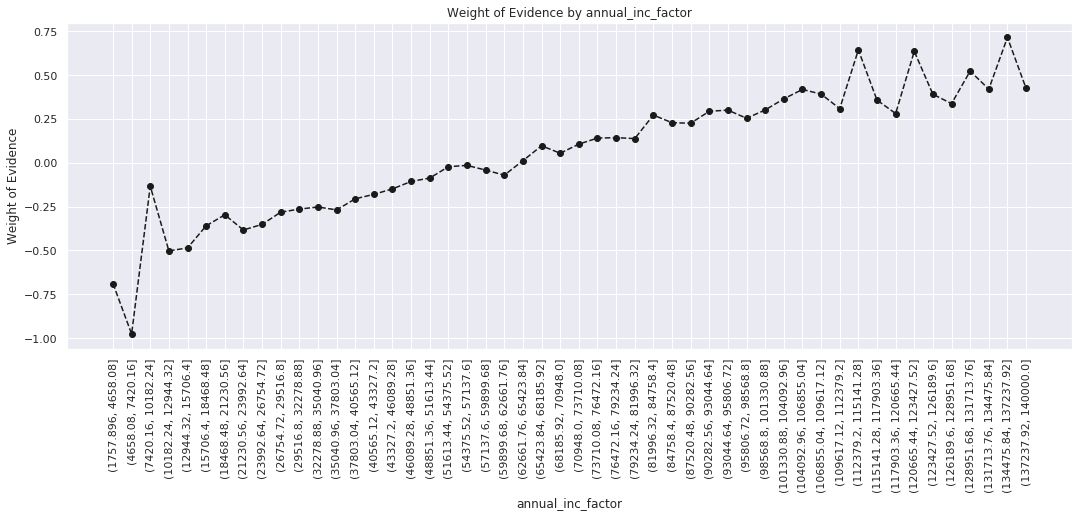

In [82]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [83]:
# WoE is monotonically decreasing with income, so we split income in 10 equal categories, each with width of 15k.
df_inputs_prepr['annual_inc:<20K'] = np.where((df_inputs_prepr['annual_inc'] <= 20000), 1, 0)
df_inputs_prepr['annual_inc:20K-30K'] = np.where((df_inputs_prepr['annual_inc'] > 20000) & (df_inputs_prepr['annual_inc'] <= 30000), 1, 0)
df_inputs_prepr['annual_inc:30K-40K'] = np.where((df_inputs_prepr['annual_inc'] > 30000) & (df_inputs_prepr['annual_inc'] <= 40000), 1, 0)
df_inputs_prepr['annual_inc:40K-50K'] = np.where((df_inputs_prepr['annual_inc'] > 40000) & (df_inputs_prepr['annual_inc'] <= 50000), 1, 0)
df_inputs_prepr['annual_inc:50K-60K'] = np.where((df_inputs_prepr['annual_inc'] > 50000) & (df_inputs_prepr['annual_inc'] <= 60000), 1, 0)
df_inputs_prepr['annual_inc:60K-70K'] = np.where((df_inputs_prepr['annual_inc'] > 60000) & (df_inputs_prepr['annual_inc'] <= 70000), 1, 0)
df_inputs_prepr['annual_inc:70K-80K'] = np.where((df_inputs_prepr['annual_inc'] > 70000) & (df_inputs_prepr['annual_inc'] <= 80000), 1, 0)
df_inputs_prepr['annual_inc:80K-90K'] = np.where((df_inputs_prepr['annual_inc'] > 80000) & (df_inputs_prepr['annual_inc'] <= 90000), 1, 0)
df_inputs_prepr['annual_inc:90K-100K'] = np.where((df_inputs_prepr['annual_inc'] > 90000) & (df_inputs_prepr['annual_inc'] <= 100000), 1, 0)
df_inputs_prepr['annual_inc:100K-120K'] = np.where((df_inputs_prepr['annual_inc'] > 100000) & (df_inputs_prepr['annual_inc'] <= 120000), 1, 0)
df_inputs_prepr['annual_inc:120K-140K'] = np.where((df_inputs_prepr['annual_inc'] > 120000) & (df_inputs_prepr['annual_inc'] <= 140000), 1, 0)
df_inputs_prepr['annual_inc:>140K'] = np.where((df_inputs_prepr['annual_inc'] > 140000), 1, 0)

In [84]:
# mths_since_last_delinq
# We have to create one category for missing values and do fine and coarse classing for the rest.
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_delinq'])]
df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'mths_since_last_delinq_factor', df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/pandas/core/algorithms.py:1926: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,mths_since_last_delinq_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.188, 3.76]",5277,0.871518,0.030531,4599.0,678.0,0.029814,0.036481,-0.201825,NaN,NaN,inf
1,"(3.76, 7.52]",11167,0.887615,0.064608,9912.0,1255.0,0.064256,0.067528,-0.049661,0.016097,0.152164,inf
2,"(7.52, 11.28]",13306,0.892830,0.076983,11880.0,1426.0,0.077014,0.076729,0.003711,0.005215,0.053372,inf
3,"(11.28, 15.04]",13216,0.888847,0.076462,11747.0,1469.0,0.076152,0.079042,-0.037256,0.003983,0.040967,inf
4,"(15.04, 18.8]",9337,0.894934,0.054020,8356.0,981.0,0.054169,0.052785,0.025891,0.006087,0.063147,inf
5,"(18.8, 22.56]",11641,0.892707,0.067350,10392.0,1249.0,0.067368,0.067205,0.002421,0.002227,0.023470,inf
6,"(22.56, 26.32]",10887,0.896298,0.062988,9758.0,1129.0,0.063258,0.060748,0.040483,0.003592,0.038062,inf
7,"(26.32, 30.08]",10560,0.895076,0.061096,9452.0,1108.0,0.061274,0.059618,0.027398,0.001223,0.013085,inf
8,"(30.08, 33.84]",7576,0.902191,0.043832,6835.0,741.0,0.044309,0.039871,0.105539,0.007115,0.078141,inf
9,"(33.84, 37.6]",9795,0.897397,0.056670,8790.0,1005.0,0.056982,0.054076,0.052355,0.004794,0.053184,inf


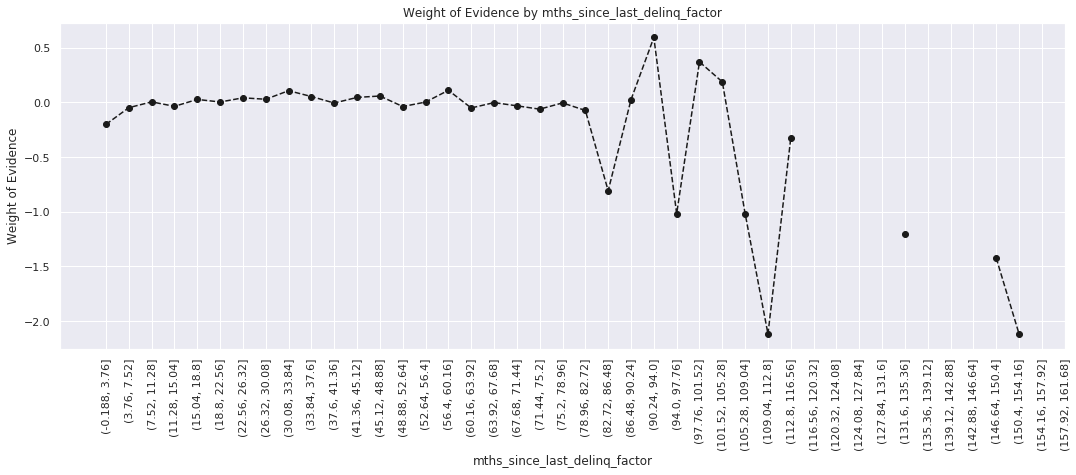

In [85]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [ ]:
# Categories: Missing, 0-3, 4-30, 31-56, >=57
df_inputs_prepr['mths_since_last_delinq:Missing'] = np.where((df_inputs_prepr['mths_since_last_delinq'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_delinq:0-3'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 0) & (df_inputs_prepr['mths_since_last_delinq'] <= 3), 1, 0)
df_inputs_prepr['mths_since_last_delinq:4-30'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 4) & (df_inputs_prepr['mths_since_last_delinq'] <= 30), 1, 0)
df_inputs_prepr['mths_since_last_delinq:31-56'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 31) & (df_inputs_prepr['mths_since_last_delinq'] <= 56), 1, 0)
df_inputs_prepr['mths_since_last_delinq:>=57'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 57), 1, 0)

### dti_factor

In [86]:
df_inputs_prepr['dti_factor'] = pd.cut(df_inputs_prepr['dti'], 50)
df_inputs_prepr.loc[:,['dti', 'dti_factor']]

,dti,dti_factor
427211,21.91,"(21.595, 22.394]"
206088,7.49,"(7.198, 7.998]"
136020,14.83,"(14.396, 15.196]"
412305,13.68,"(13.597, 14.396]"
36159,22.54,"(22.394, 23.194]"
...,...,...
259178,15.80,"(15.196, 15.996]"
365838,11.99,"(11.197, 11.997]"
131932,3.98,"(3.199, 3.999]"
146867,24.90,"(24.794, 25.594]"


In [87]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'dti_factor', df_targets_prepr)
df_temp

,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.04, 0.8]",1553,0.898905,0.004163,1396.0,157.0,0.004202,0.003850,0.087376,NaN,NaN,0.026725
1,"(0.8, 1.6]",1965,0.896692,0.005268,1762.0,203.0,0.005303,0.004978,0.063254,0.002213,0.024122,0.026725
2,"(1.6, 2.399]",2509,0.910323,0.006726,2284.0,225.0,0.006874,0.005518,0.219838,0.013631,0.156584,0.026725
3,"(2.399, 3.199]",3234,0.910019,0.008670,2943.0,291.0,0.008858,0.007136,0.216117,0.000304,0.003722,0.026725
4,"(3.199, 3.999]",4124,0.907856,0.011055,3744.0,380.0,0.011269,0.009319,0.189994,0.002162,0.026123,0.026725
5,"(3.999, 4.799]",5037,0.917213,0.013503,4620.0,417.0,0.013905,0.010226,0.307319,0.009356,0.117325,0.026725
6,"(4.799, 5.599]",5989,0.911671,0.016055,5460.0,529.0,0.016433,0.012973,0.236471,0.005541,0.070848,0.026725
7,"(5.599, 6.398]",6781,0.914909,0.018178,6204.0,577.0,0.018673,0.014150,0.277362,0.003238,0.040892,0.026725
8,"(6.398, 7.198]",7665,0.913372,0.020548,7001.0,664.0,0.021071,0.016283,0.257781,0.001537,0.019581,0.026725
9,"(7.198, 7.998]",8747,0.915514,0.023449,8008.0,739.0,0.024102,0.018123,0.285153,0.002141,0.027372,0.026725


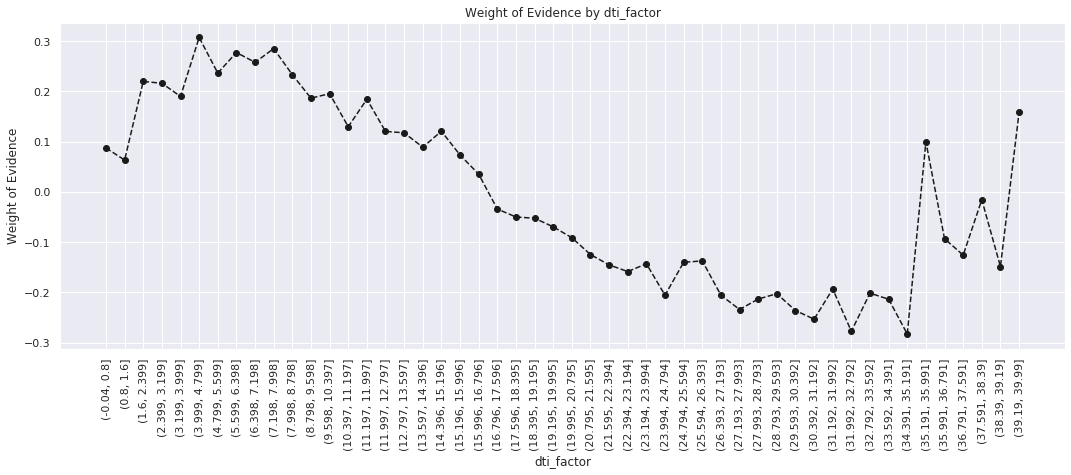

In [88]:
plot_by_woe(df_temp, 90)

In [ ]:
# Categories:
df_inputs_prepr['dti:<=1.4'] = np.where((df_inputs_prepr['dti'] <= 1.4), 1, 0)
df_inputs_prepr['dti:1.4-3.5'] = np.where((df_inputs_prepr['dti'] > 1.4) & (df_inputs_prepr['dti'] <= 3.5), 1, 0)
df_inputs_prepr['dti:3.5-7.7'] = np.where((df_inputs_prepr['dti'] > 3.5) & (df_inputs_prepr['dti'] <= 7.7), 1, 0)
df_inputs_prepr['dti:7.7-10.5'] = np.where((df_inputs_prepr['dti'] > 7.7) & (df_inputs_prepr['dti'] <= 10.5), 1, 0)
df_inputs_prepr['dti:10.5-16.1'] = np.where((df_inputs_prepr['dti'] > 10.5) & (df_inputs_prepr['dti'] <= 16.1), 1, 0)
df_inputs_prepr['dti:16.1-20.3'] = np.where((df_inputs_prepr['dti'] > 16.1) & (df_inputs_prepr['dti'] <= 20.3), 1, 0)
df_inputs_prepr['dti:20.3-21.7'] = np.where((df_inputs_prepr['dti'] > 20.3) & (df_inputs_prepr['dti'] <= 21.7), 1, 0)
df_inputs_prepr['dti:21.7-22.4'] = np.where((df_inputs_prepr['dti'] > 21.7) & (df_inputs_prepr['dti'] <= 22.4), 1, 0)
df_inputs_prepr['dti:22.4-35'] = np.where((df_inputs_prepr['dti'] > 22.4) & (df_inputs_prepr['dti'] <= 35), 1, 0)
df_inputs_prepr['dti:>35'] = np.where((df_inputs_prepr['dti'] > 35), 1, 0)

In [ ]:
df_inputs_prepr['mths_since_last_record'].isnull().sum()

In [89]:
# mths_since_last_record
# We have to create one category for missing values and do fine and coarse classing for the rest.
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_record'])]
#sum(loan_data_temp['mths_since_last_record'].isnull())
df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'mths_since_last_record_factor', df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,mths_since_last_record_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.121, 2.42]",1086,0.764273,0.021691,830.0,256.0,0.018569,0.047672,-0.942830,NaN,NaN,0.080659
1,"(2.42, 4.84]",76,0.894737,0.001518,68.0,8.0,0.001521,0.001490,0.020988,0.130464,0.963818,0.080659
2,"(4.84, 7.26]",163,0.914110,0.003256,149.0,14.0,0.003334,0.002607,0.245810,0.019374,0.224823,0.080659
3,"(7.26, 9.68]",156,0.903846,0.003116,141.0,15.0,0.003155,0.002793,0.121631,0.010264,0.124179,0.080659
4,"(9.68, 12.1]",292,0.907534,0.005832,265.0,27.0,0.005929,0.005028,0.164814,0.003688,0.043183,0.080659
5,"(12.1, 14.52]",207,0.917874,0.004134,190.0,17.0,0.004251,0.003166,0.294732,0.010340,0.129918,0.080659
6,"(14.52, 16.94]",210,0.928571,0.004194,195.0,15.0,0.004363,0.002793,0.445871,0.010697,0.151139,0.080659
7,"(16.94, 19.36]",334,0.907186,0.006671,303.0,31.0,0.006779,0.005773,0.160667,0.021386,0.285204,0.080659
8,"(19.36, 21.78]",283,0.936396,0.005652,265.0,18.0,0.005929,0.003352,0.570280,0.029210,0.409612,0.080659
9,"(21.78, 24.2]",455,0.898901,0.009088,409.0,46.0,0.009151,0.008566,0.065995,0.037495,0.504284,0.080659


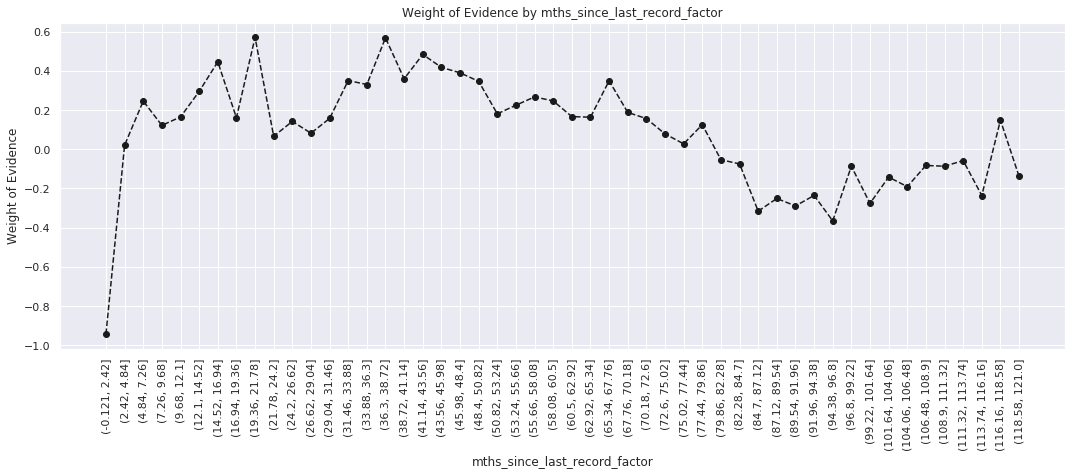

In [90]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [ ]:
# Categories: 'Missing', '0-2', '3-20', '21-31', '32-80', '81-86', '>86'
df_inputs_prepr['mths_since_last_record:Missing'] = np.where((df_inputs_prepr['mths_since_last_record'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_record:0-2'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 0) & (df_inputs_prepr['mths_since_last_record'] <= 2), 1, 0)
df_inputs_prepr['mths_since_last_record:3-20'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 3) & (df_inputs_prepr['mths_since_last_record'] <= 20), 1, 0)
df_inputs_prepr['mths_since_last_record:21-31'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 21) & (df_inputs_prepr['mths_since_last_record'] <= 31), 1, 0)
df_inputs_prepr['mths_since_last_record:32-80'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 32) & (df_inputs_prepr['mths_since_last_record'] <= 80), 1, 0)
df_inputs_prepr['mths_since_last_record:81-86'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 81) & (df_inputs_prepr['mths_since_last_record'] <= 86), 1, 0)
df_inputs_prepr['mths_since_last_record:>86'] = np.where((df_inputs_prepr['mths_since_last_record'] > 86), 1, 0)

## Preprocessing the Test Dataset

In [ ]:
#loan_data_inputs_train = df_inputs_prepr
#loan_data_inputs_test = df_inputs_prepr

In [ ]:
#loan_data_inputs_train.to_csv('gs://credit-risk-modeling/loan_data_inputs_train.csv')
#loan_data_targets_train.to_csv('gs://credit-risk-modeling/loan_data_targets_train.csv')
#loan_data_inputs_test.to_csv('gs://credit-risk-modeling/loan_data_inputs_test.csv')
#loan_data_targets_test.to_csv('gs://credit-risk-modeling/loan_data_targets_test.csv')